# Extension 6.1: Adaptive Re-ranking Strategy

## 1. Threshold Selection and Training
In this section, we define what a "hard query" is and determine an optimal inlier threshold $\tau$.
The goal is to stop the re-ranking process if the first retrieved candidate already shows a high number of inliers,
assuming the prediction is correct.

**Strategy:**
* Use **SVOX Sun Train** and **SVOX Night Train** to analyze the inlier distribution.
* Find the threshold $\tau$ that maximizes the F1-score or balances Precision/Recall on the training set.

Mounting Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Selezione della Soglia (SVOX Sun Train)
In questa fase analizziamo i dati di addestramento per definire cosa rende una query "facile" o "difficile". Utilizziamo l'F1-Score come metrica di riferimento perché bilancia la precisione (non scambiare un errore per un match facile) e la recall (identificare correttamente i match facili per risparmiare calcoli).

## LoFTR

### TAU SVOX Sun Train LoFTR

Lettura 712 query...


100%|██████████| 712/712 [00:05<00:00, 140.68it/s]


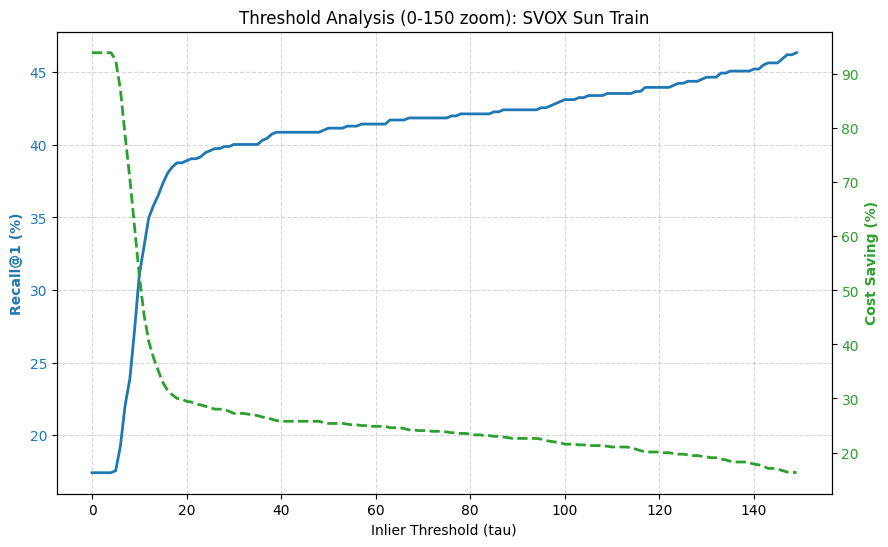


--- THRESHOLD TRADE-OFF TABLE (0-100, Step 5) ---
Tau   | Recall     | Saving     | F1-Score   | Note
-----------------------------------------------------------------
0     | 17.42%   | 93.99%   | 0.6809     | 
5     | 17.56%   | 92.66%   | 0.6854     | 
10    | 31.04%   | 52.74%   | 0.7050     | 
15    | 37.36%   | 32.91%   | 0.7273     | ⭐ BEST
20    | 38.90%   | 29.48%   | 0.7220     | 
25    | 39.61%   | 28.29%   | 0.7160     | 
30    | 40.03%   | 27.23%   | 0.7086     | 
35    | 40.03%   | 26.83%   | 0.7088     | 
40    | 40.87%   | 25.78%   | 0.6904     | 
45    | 40.87%   | 25.78%   | 0.6904     | 
50    | 41.15%   | 25.38%   | 0.6834     | 
55    | 41.29%   | 25.12%   | 0.6786     | 
60    | 41.43%   | 24.85%   | 0.6739     | 
65    | 41.71%   | 24.59%   | 0.6691     | 
70    | 41.85%   | 24.06%   | 0.6594     | 
75    | 41.85%   | 23.79%   | 0.6545     | 
80    | 42.13%   | 23.40%   | 0.6471     | 
85    | 42.28%   | 23.00%   | 0.6396     | 
90    | 42.42%   | 22.60%   | 0.6

In [ ]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from sklearn.metrics import f1_score

# ==============================================================================
# 1. CONFIGURAZIONE
# ==============================================================================
BASE_PATH = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_svox/train/svox_sun_train"
PREDS_FOLDER = os.path.join(BASE_PATH, 'preds_loftr')
CSV_FILE = os.path.join(BASE_PATH, 'stats_preds_loftr.csv')

# Latenze (secondi)
TIME_GLOBAL = 0.20
TIME_RERANK = 3.20

# ==============================================================================
# 2. CARICAMENTO DATI
# ==============================================================================
def get_rank0_data(preds_folder, csv_file):
    if not os.path.exists(csv_file):
        print(f"❌ Errore: CSV non trovato in {csv_file}")
        return pd.DataFrame()

    df = pd.read_csv(csv_file)
    results = []

    print(f"Lettura {len(df)} query...")
    for _, row in tqdm(df.iterrows(), total=len(df)):
        try:
            q_id = int(float(row['query_id']))
            final_is_correct = row['is_correct']

            # Cerca il file .torch
            possible_names = [f"{q_id}.torch", f"{q_id:03d}.torch", f"{q_id:05d}.torch"]
            torch_path = None
            for name in possible_names:
                p = os.path.join(preds_folder, name)
                if os.path.exists(p):
                    torch_path = p
                    break

            if torch_path:
                data = torch.load(torch_path, weights_only=False)
                inliers_rank0 = data[0]['num_inliers']

                # Rank 0 è corretto se è il migliore E il risultato finale è corretto
                all_inliers = [x['num_inliers'] for x in data]
                is_rank0_best = (inliers_rank0 == max(all_inliers))
                rank0_ok = 1 if (is_rank0_best and final_is_correct == 1) else 0

                results.append({
                    'inliers_rank0': inliers_rank0,
                    'rank0_is_correct': rank0_ok,
                    'final_is_correct': final_is_correct
                })
        except Exception:
            continue

    return pd.DataFrame(results)

# ==============================================================================
# 3. ANALISI
# ==============================================================================
def run_analysis(df):
    # Calcoliamo tutto step 1 per precisione grafica, ma stampiamo solo step 5
    max_inl = int(df['inliers_rank0'].max())
    thresholds = np.arange(0, max_inl + 1, 1)

    recalls, savings, f1_vals = [], [], []
    total = len(df)
    full_time = total * (TIME_GLOBAL + TIME_RERANK)

    for t in thresholds:
        is_easy = df['inliers_rank0'] > t

        # Recall@1
        hits = np.sum(np.where(is_easy, df['rank0_is_correct'], df['final_is_correct']))
        recalls.append((hits / total) * 100)

        # Saving
        n_easy = np.sum(is_easy)
        n_hard = total - n_easy
        curr_time = (n_easy * TIME_GLOBAL) + (n_hard * (TIME_GLOBAL + TIME_RERANK))
        savings.append((1 - (curr_time / full_time)) * 100)

        # F1 Score
        y_pred = (df['inliers_rank0'] > t).astype(int)
        f1_vals.append(f1_score(df['final_is_correct'], y_pred))

    return thresholds, recalls, savings, f1_vals

# ==============================================================================
# MAIN
# ==============================================================================
if __name__ == "__main__":
    df_results = get_rank0_data(PREDS_FOLDER, CSV_FILE)

    if not df_results.empty:
        th, rec, sav, f1 = run_analysis(df_results)

        # Trova il Best Tau GLOBALE (per riferimento)
        best_idx = np.argmax(f1)
        best_tau_global = th[best_idx]

        # --- GRAFICO (Zoom 0-150 per leggibilità) ---
        limit_idx = min(150, len(th))

        fig, ax1 = plt.subplots(figsize=(10, 6))
        ax1.set_xlabel('Inlier Threshold (tau)')
        ax1.set_ylabel('Recall@1 (%)', color='tab:blue', fontweight='bold')
        ax1.plot(th[:limit_idx], rec[:limit_idx], color='tab:blue', linewidth=2, label='Recall@1')
        ax1.tick_params(axis='y', labelcolor='tab:blue')
        ax1.grid(True, linestyle='--', alpha=0.5)

        ax2 = ax1.twinx()
        ax2.set_ylabel('Cost Saving (%)', color='tab:green', fontweight='bold')
        ax2.plot(th[:limit_idx], sav[:limit_idx], color='tab:green', linestyle='--', linewidth=2, label='Cost Saving')
        ax2.tick_params(axis='y', labelcolor='tab:green')

        plt.title('Threshold Analysis (0-150 zoom): SVOX Sun Train')
        plt.show()

        # --- TABELLA 0-100 STEP 5 ---
        print(f"\n--- THRESHOLD TRADE-OFF TABLE (0-100, Step 5) ---")
        print(f"{'Tau':<5} | {'Recall':<10} | {'Saving':<10} | {'F1-Score':<10} | {'Note'}")
        print("-" * 65)

        # Iteriamo solo sui multipli di 5 fino a 100
        for t_val in range(0, 101, 5):
            if t_val < len(th): # Controllo bounds
                idx = t_val # Dato che th è arange(0, max, 1), l'indice corrisponde al valore

                # Controlliamo se è il migliore tra quelli stampati o vicino al globale
                is_best = (abs(t_val - best_tau_global) < 3) # Evidenzia se vicino al best reale
                marker = "⭐ BEST" if is_best else ""

                print(f"{t_val:<5} | {rec[idx]:.2f}%   | {sav[idx]:.2f}%   | {f1[idx]:.4f}     | {marker}")

        print("-" * 65)
        print(f"Nota: Il Best Tau matematico esatto (step=1) è: {best_tau_global}")

### TAU Svox Night train Loftr

--- Analisi SVOX NIGHT TRAIN (LoFTR) ---
Lettura 702 query...


100%|██████████| 702/702 [02:58<00:00,  3.93it/s]


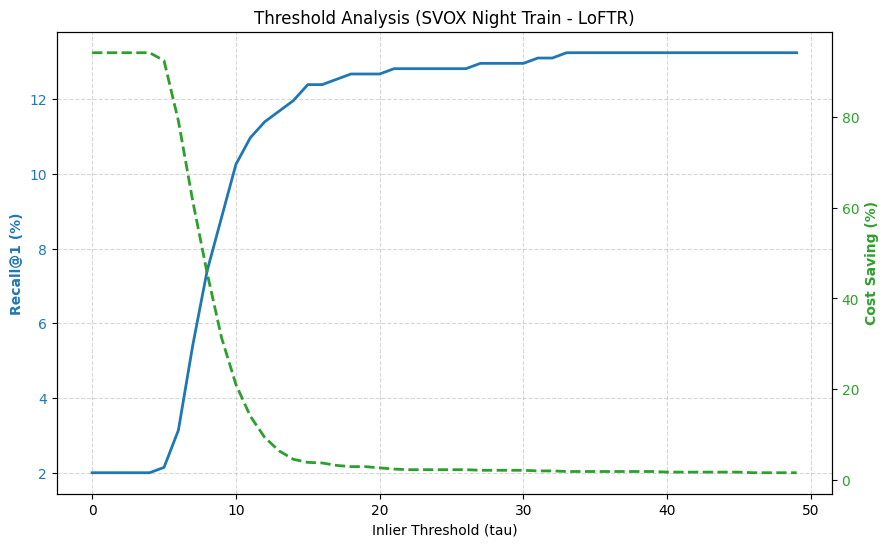


--- THRESHOLD TRADE-OFF TABLE (0-100, Step 5) ---
Tau   | Recall     | Saving     | F1-Score   | Note
-----------------------------------------------------------------
0     | 1.99%   | 94.12%   | 0.2406     | 
5     | 2.14%   | 92.37%   | 0.2420     | 
10    | 10.26%   | 21.05%   | 0.2925     | 
15    | 12.39%   | 3.89%   | 0.3360     | ⭐ BEST
20    | 12.68%   | 2.68%   | 0.3276     | 
25    | 12.82%   | 2.28%   | 0.3009     | 
30    | 12.96%   | 2.15%   | 0.2857     | 
35    | 13.25%   | 1.88%   | 0.2545     | 
40    | 13.25%   | 1.74%   | 0.2385     | 
45    | 13.25%   | 1.74%   | 0.2385     | 
50    | 13.39%   | 1.47%   | 0.2056     | 
55    | 13.39%   | 1.47%   | 0.2056     | 
60    | 13.39%   | 1.34%   | 0.1887     | 
65    | 13.39%   | 1.34%   | 0.1887     | 
70    | 13.39%   | 1.21%   | 0.1714     | 
75    | 13.39%   | 1.07%   | 0.1538     | 
80    | 13.39%   | 1.07%   | 0.1538     | 
85    | 13.39%   | 1.07%   | 0.1538     | 
90    | 13.39%   | 1.07%   | 0.1538     | 
95    |

In [2]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from sklearn.metrics import f1_score

# ==============================================================================
# 1. CONFIGURAZIONE
# ==============================================================================
# Nota: Ho aggiunto "_train" alla fine perché solitamente la cartella si chiama così.
# Se la tua cartella si chiama solo "svox_night", cancella "_train" dalla stringa qui sotto.
BASE_PATH = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_svox/train/svox_night"

PREDS_FOLDER = os.path.join(BASE_PATH, 'preds_loftr')
CSV_FILE = os.path.join(BASE_PATH, 'stats_preds_loftr.csv')

# Latenze (secondi)
TIME_GLOBAL = 0.20
TIME_RERANK = 3.20

# ==============================================================================
# 2. CARICAMENTO DATI
# ==============================================================================
def get_rank0_data(preds_folder, csv_file):
    print(f"--- Analisi SVOX NIGHT TRAIN (LoFTR) ---")
    if not os.path.exists(csv_file):
        print(f"❌ Errore: CSV non trovato in {csv_file}")
        print("Verifica se la cartella si chiama 'svox_night' o 'svox_night_train'")
        return pd.DataFrame()

    df = pd.read_csv(csv_file)
    results = []

    print(f"Lettura {len(df)} query...")
    for _, row in tqdm(df.iterrows(), total=len(df)):
        try:
            q_id = int(float(row['query_id']))
            final_is_correct = row['is_correct']

            # Cerca il file .torch
            possible_names = [f"{q_id}.torch", f"{q_id:03d}.torch", f"{q_id:05d}.torch"]
            torch_path = None
            for name in possible_names:
                p = os.path.join(preds_folder, name)
                if os.path.exists(p):
                    torch_path = p
                    break

            if torch_path:
                data = torch.load(torch_path, weights_only=False)
                inliers_rank0 = data[0]['num_inliers']

                # Rank 0 è corretto se è il migliore E il risultato finale è corretto
                all_inliers = [x['num_inliers'] for x in data]
                is_rank0_best = (inliers_rank0 == max(all_inliers))
                rank0_ok = 1 if (is_rank0_best and final_is_correct == 1) else 0

                results.append({
                    'inliers_rank0': inliers_rank0,
                    'rank0_is_correct': rank0_ok,
                    'final_is_correct': final_is_correct
                })
        except Exception:
            continue

    return pd.DataFrame(results)

# ==============================================================================
# 3. ANALISI
# ==============================================================================
def run_analysis(df):
    max_inl = int(df['inliers_rank0'].max())
    thresholds = np.arange(0, max_inl + 1, 1)

    recalls, savings, f1_vals = [], [], []
    total = len(df)
    full_time = total * (TIME_GLOBAL + TIME_RERANK)

    for t in thresholds:
        is_easy = df['inliers_rank0'] > t

        # Recall@1
        hits = np.sum(np.where(is_easy, df['rank0_is_correct'], df['final_is_correct']))
        recalls.append((hits / total) * 100)

        # Saving
        n_easy = np.sum(is_easy)
        n_hard = total - n_easy
        curr_time = (n_easy * TIME_GLOBAL) + (n_hard * (TIME_GLOBAL + TIME_RERANK))
        savings.append((1 - (curr_time / full_time)) * 100)

        # F1 Score
        y_pred = (df['inliers_rank0'] > t).astype(int)
        f1_vals.append(f1_score(df['final_is_correct'], y_pred))

    return thresholds, recalls, savings, f1_vals

# ==============================================================================
# MAIN
# ==============================================================================
if __name__ == "__main__":
    df_results = get_rank0_data(PREDS_FOLDER, CSV_FILE)

    if not df_results.empty:
        th, rec, sav, f1 = run_analysis(df_results)

        # Trova il Best Tau GLOBALE
        best_idx = np.argmax(f1)
        best_tau_global = th[best_idx]

        # --- GRAFICO (Zoom 0-50 per la notte) ---
        limit_idx = min(50, len(th))

        fig, ax1 = plt.subplots(figsize=(10, 6))
        ax1.set_xlabel('Inlier Threshold (tau)')
        ax1.set_ylabel('Recall@1 (%)', color='tab:blue', fontweight='bold')
        ax1.plot(th[:limit_idx], rec[:limit_idx], color='tab:blue', linewidth=2, label='Recall@1')
        ax1.tick_params(axis='y', labelcolor='tab:blue')
        ax1.grid(True, linestyle='--', alpha=0.5)

        ax2 = ax1.twinx()
        ax2.set_ylabel('Cost Saving (%)', color='tab:green', fontweight='bold')
        ax2.plot(th[:limit_idx], sav[:limit_idx], color='tab:green', linestyle='--', linewidth=2, label='Cost Saving')
        ax2.tick_params(axis='y', labelcolor='tab:green')

        plt.title('Threshold Analysis (SVOX Night Train - LoFTR)')
        plt.show()

        # --- TABELLA 0-100 STEP 5 ---
        print(f"\n--- THRESHOLD TRADE-OFF TABLE (0-100, Step 5) ---")
        print(f"{'Tau':<5} | {'Recall':<10} | {'Saving':<10} | {'F1-Score':<10} | {'Note'}")
        print("-" * 65)

        for t_val in range(0, 101, 5):
            if t_val < len(th):
                idx = t_val
                # Evidenzia se vicino al best reale (tolleranza ridotta a 2 per la notte)
                is_best = (abs(t_val - best_tau_global) <= 2)
                marker = "⭐ BEST" if is_best else ""

                print(f"{t_val:<5} | {rec[idx]:.2f}%   | {sav[idx]:.2f}%   | {f1[idx]:.4f}     | {marker}")

        print("-" * 65)
        print(f"Nota: Il Best Tau matematico esatto (step=1) è: {best_tau_global}")

### Validazione su sf_xs val
**Tau scelto: 15**

Obiettivo:Dopo aver determinato la soglia ottimale sui dataset di training (SVOX Sun/Night), è fondamentale validarne la robustezza su un dataset mai visto e proveniente da un dominio geografico diverso: San Francisco eXtra Small (SF-XS Val).Metodologia:
* Applichiamo la soglia "congelata" derivata dall'analisi precedente:LoFTR: $\tau = 15$ (Valore selezionato dall'analisi su SVOX)

Valutiamo la Recall@1 e il Risparmio Computazionale su SF-XS Val utilizzando questo valore fisso. Se il sistema è robusto, ci aspettiamo che la soglia $\tau=15$ mantenga una buona precisione senza sacrificare troppo il risparmio, confermando che il parametro non è in "overfitting" sui dati di training.


--- Caricamento LOFTR su SF-XS VAL ---
📄 CSV trovato: loftr_val.csv


Loading loftr: 100%|██████████| 1000/1000 [04:26<00:00,  3.75it/s]


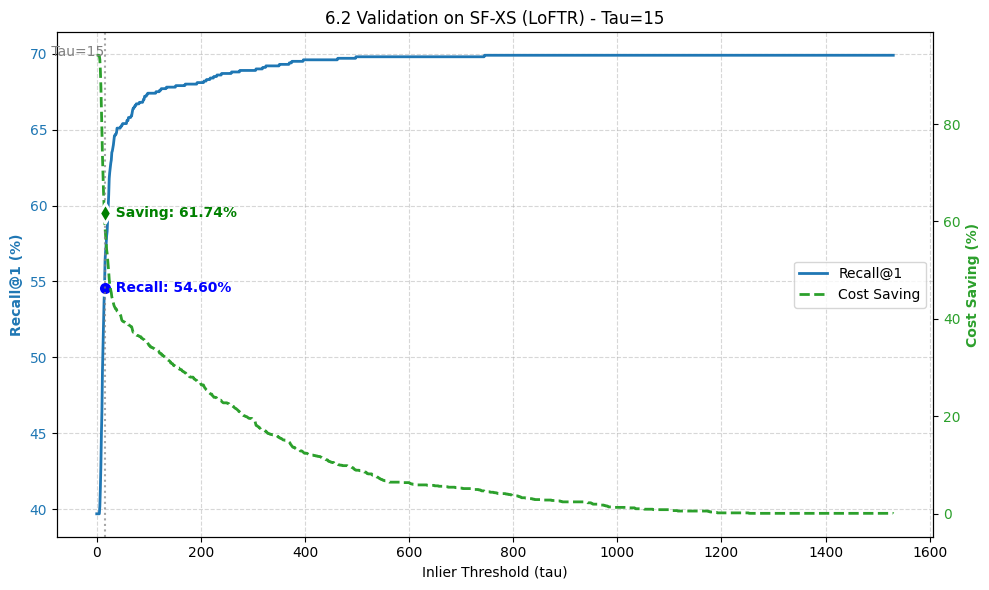


🏆 VALIDATION RESULTS (SF-XS VAL - LoFTR)
Method     | Chosen Tau | Recall@1   | Saving    
--------------------------------------------------
LoFTR      | 15         | 54.60     % | 61.74     %
--------------------------------------------------


In [5]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

# ==============================================================================
# 1. CONFIGURAZIONE VALIDAZIONE (SF-XS VAL)
# ==============================================================================
# Percorso base confermato dal tuo snippet
BASE_PATH = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_sf_xs/val"

# SOGLIA SCELTA (Congelata dalla fase di Training SVOX Sun/Night)
CHOSEN_TAU_LOFTR = 15

# Latenze (secondi) per il calcolo del risparmio
TIME_GLOBAL = 0.20
TIME_RERANK = 3.20

# ==============================================================================
# 2. FUNZIONI DI CARICAMENTO E ANALISI
# ==============================================================================
def get_rank0_data(base_path, matcher_name):
    # Definizione nomi file flessibile (adatta ai tuoi file caricati)
    folder_name = 'preds_loftr'

    # Cerchiamo il CSV corretto: o quello standard o quello personalizzato "loftr_val.csv"
    possible_csvs = [
        os.path.join(base_path, f'stats_preds_{matcher_name}.csv'),
        os.path.join(base_path, f'{matcher_name}_val.csv')
    ]

    csv_file = None
    for p in possible_csvs:
        if os.path.exists(p):
            csv_file = p
            break

    preds_folder = os.path.join(base_path, folder_name)

    print(f"\n--- Caricamento {matcher_name.upper()} su SF-XS VAL ---")
    if not csv_file:
        print(f"❌ Errore: Nessun CSV trovato in {base_path}")
        return pd.DataFrame()

    print(f"📄 CSV trovato: {os.path.basename(csv_file)}")
    df = pd.read_csv(csv_file)
    results = []

    # Lettura e parsing
    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Loading {matcher_name}"):
        try:
            q_id = int(float(row['query_id']))
            final_is_correct = row['is_correct']

            # Cerca file .torch (gestione formati diversi 0.torch, 000.torch, ecc)
            possible_names = [f"{q_id}.torch", f"{q_id:03d}.torch", f"{q_id:05d}.torch"]
            torch_path = None
            for name in possible_names:
                p = os.path.join(preds_folder, name)
                if os.path.exists(p):
                    torch_path = p
                    break

            if torch_path:
                data = torch.load(torch_path, weights_only=False)
                inliers_rank0 = data[0]['num_inliers']

                # Calcola se il Rank 0 (Global Retrieval) era corretto
                all_inliers = [x['num_inliers'] for x in data]
                is_rank0_best = (inliers_rank0 == max(all_inliers))
                rank0_ok = 1 if (is_rank0_best and final_is_correct == 1) else 0

                results.append({
                    'inliers_rank0': inliers_rank0,
                    'rank0_is_correct': rank0_ok,
                    'final_is_correct': final_is_correct
                })
        except:
            continue

    return pd.DataFrame(results)

def validate_matcher(df, chosen_tau):
    # Analisi su tutto il range per il grafico
    max_inl = int(df['inliers_rank0'].max())
    thresholds = np.arange(0, max_inl + 1, 1)
    recalls, savings = [], []
    total = len(df)
    full_time = total * (TIME_GLOBAL + TIME_RERANK)

    # Calcolo curve complete
    for t in thresholds:
        is_easy = df['inliers_rank0'] > t

        # Recall@1: Se Easy usa Rank0, Se Hard usa Final (Reranked)
        hits = np.sum(np.where(is_easy, df['rank0_is_correct'], df['final_is_correct']))
        recalls.append((hits / total) * 100)

        # Saving: Tempo risparmiato
        n_easy = np.sum(is_easy)
        n_hard = total - n_easy
        curr_time = (n_easy * TIME_GLOBAL) + (n_hard * (TIME_GLOBAL + TIME_RERANK))
        savings.append((1 - (curr_time / full_time)) * 100)

    # Estrazione dati puntuali per il TAU SCELTO
    if chosen_tau < len(thresholds):
        val_recall = recalls[chosen_tau]
        val_saving = savings[chosen_tau]
    else:
        val_recall = recalls[-1]
        val_saving = savings[-1]

    return thresholds, recalls, savings, val_recall, val_saving

# ==============================================================================
# 3. MAIN: VALIDAZIONE E PLOT (SOLO LOFTR)
# ==============================================================================
if __name__ == "__main__":
    # --- 1. Caricamento Dati LoFTR ---
    df_loftr = get_rank0_data(BASE_PATH, 'loftr')

    if not df_loftr.empty:
        # Validazione
        th_l, rec_l, sav_l, val_rec_l, val_sav_l = validate_matcher(df_loftr, CHOSEN_TAU_LOFTR)

        # --- 2. GRAFICO DI VALIDAZIONE ---
        fig, ax1 = plt.subplots(figsize=(10, 6))

        ax1.set_xlabel('Inlier Threshold (tau)')
        ax1.set_ylabel('Recall@1 (%)', color='tab:blue', fontweight='bold')
        ax1.grid(True, linestyle='--', alpha=0.5)

        # Curva Recall (Blu)
        l1, = ax1.plot(th_l, rec_l, color='tab:blue', linestyle='-', linewidth=2, label='Recall@1')
        ax1.tick_params(axis='y', labelcolor='tab:blue')

        # Curva Saving (Verde - Asse Destro)
        ax2 = ax1.twinx()
        ax2.set_ylabel('Cost Saving (%)', color='tab:green', fontweight='bold')
        l2, = ax2.plot(th_l, sav_l, color='tab:green', linestyle='--', linewidth=2, label='Cost Saving')
        ax2.tick_params(axis='y', labelcolor='tab:green')

        # --- PUNTO DI VALIDAZIONE (TAU = 15) ---
        # Pallino sulla Recall
        ax1.scatter(CHOSEN_TAU_LOFTR, val_rec_l, color='blue', s=100, zorder=5, edgecolors='white', linewidth=2)
        ax1.text(CHOSEN_TAU_LOFTR + 2, val_rec_l, f"  Recall: {val_rec_l:.2f}%", color='blue', fontsize=10, fontweight='bold', va='center')

        # Pallino sul Saving
        ax2.scatter(CHOSEN_TAU_LOFTR, val_sav_l, color='green', s=100, marker='d', zorder=5, edgecolors='white', linewidth=2)
        ax2.text(CHOSEN_TAU_LOFTR + 2, val_sav_l, f"  Saving: {val_sav_l:.2f}%", color='green', fontsize=10, fontweight='bold', va='center')

        # Linea verticale sul Tau scelto
        plt.axvline(x=CHOSEN_TAU_LOFTR, color='gray', linestyle=':', alpha=0.7)
        plt.text(CHOSEN_TAU_LOFTR, ax2.get_ylim()[1]*0.95, f" Tau={CHOSEN_TAU_LOFTR}", color='gray', ha='right', fontsize=10)

        plt.title(f'6.2 Validation on SF-XS (LoFTR) - Tau={CHOSEN_TAU_LOFTR}')

        # Legenda combinata
        lines = [l1, l2]
        ax1.legend(lines, [l.get_label() for l in lines], loc='center right')

        plt.tight_layout()
        plt.show()

        # --- STAMPA TABELLA RIASSUNTIVA ---
        print("\n🏆 VALIDATION RESULTS (SF-XS VAL - LoFTR)")
        print(f"{'Method':<10} | {'Chosen Tau':<10} | {'Recall@1':<10} | {'Saving':<10}")
        print("-" * 50)
        print(f"{'LoFTR':<10} | {CHOSEN_TAU_LOFTR:<10} | {val_rec_l:<10.2f}% | {val_sav_l:<10.2f}%")
        print("-" * 50)
    else:
        print("❌ Nessun dato trovato per LoFTR. Controlla il percorso e i nomi dei file.")

### Test svox_sun e svox_night
Obiettivo:
Valutare le prestazioni finali della strategia di Adaptive Re-ranking (LoFTR) sui dataset di test di SVOX.
Utilizziamo la soglia $\tau = 15$, determinata in fase di training e validata su SF-XS.
Dataset di Test:

* SVOX Sun Test: Rappresenta lo scenario "standard" (diurno), simile al training set ma con query mai viste.

* SVOX Night Test: Rappresenta lo scenario "sfidante" (notturno). Qui ci aspettiamo che il sistema, grazie alla soglia adattiva, riconosca la difficoltà e attivi il re-ranking più frequentemente (basso risparmio) per preservare la Recall.

Metriche: Confronteremo Recall@1 e Risparmio Computazionale ottenuto applicando la soglia fissa.


--- Caricamento SVOX Sun Test ---
📄 CSV trovato: loftr_queries_sun.csv


Reading SVOX Sun Test: 100%|██████████| 854/854 [00:08<00:00, 105.41it/s]


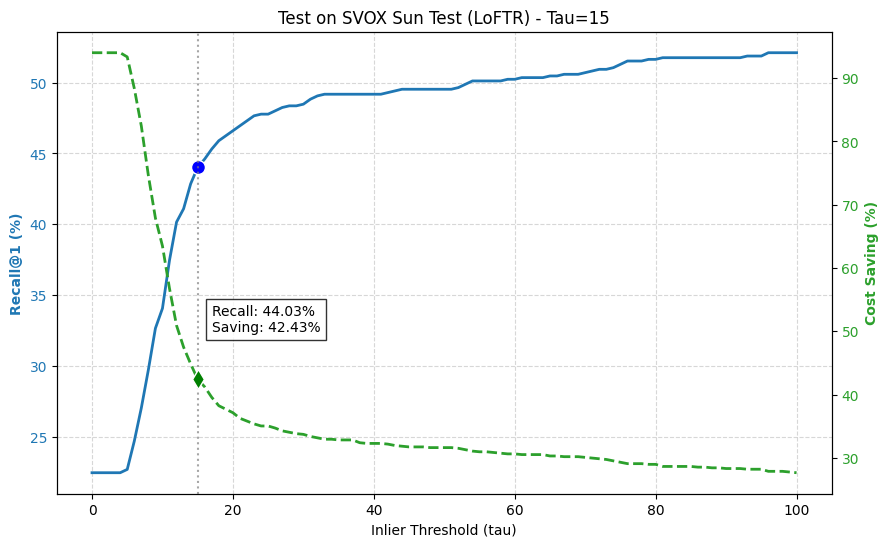


--- Caricamento SVOX Night Test ---
📄 CSV trovato: loftr_queries_night.csv


Reading SVOX Night Test: 100%|██████████| 823/823 [00:05<00:00, 145.85it/s]


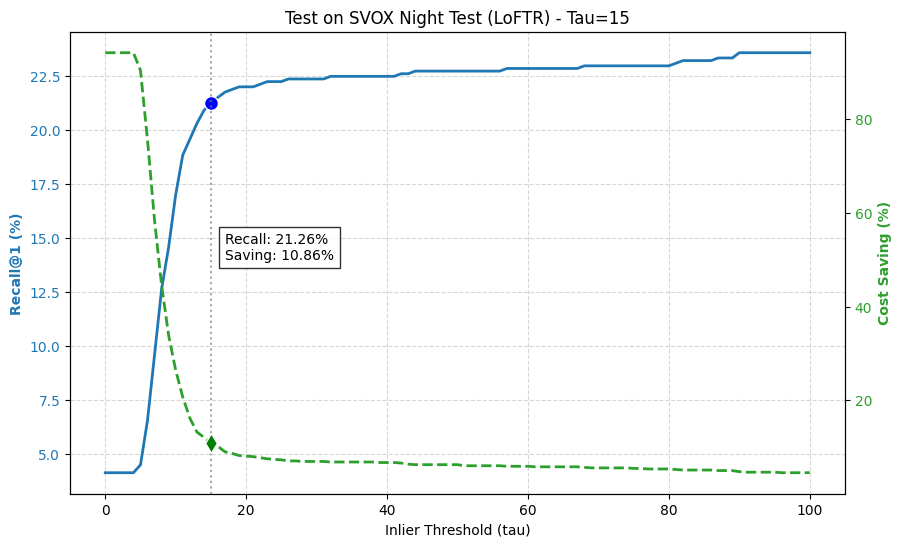



📊 FINAL TEST RESULTS (LoFTR - Adaptive Tau=15)
Dataset              | Recall@1     | Saving      
------------------------------------------------------------
SVOX Sun Test        | 44.03      % | 42.43      %
SVOX Night Test      | 21.26      % | 10.86      %


In [8]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

# ==============================================================================
# 1. CONFIGURAZIONE
# ==============================================================================
# Percorsi specifici che mi hai indicato
PATH_SUN_TEST = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_svox/test/svox_sun"
PATH_NIGHT_TEST = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_svox/test/svox_night"

CHOSEN_TAU = 15
TIME_GLOBAL = 0.20
TIME_RERANK = 3.20

# ==============================================================================
# 2. CARICAMENTO DATI
# ==============================================================================
def get_test_data(base_path, dataset_name):
    folder_name = 'preds_loftr'

    # Cerchiamo i file specifici visti nel tuo screenshot
    possible_csvs = [
        os.path.join(base_path, 'loftr_queries_sun.csv'),
        os.path.join(base_path, 'loftr_queries_night.csv'),
        os.path.join(base_path, 'loftr_test.csv'),
        os.path.join(base_path, 'stats_preds_loftr.csv')
    ]

    csv_file = None
    for p in possible_csvs:
        if os.path.exists(p):
            csv_file = p
            break

    preds_folder = os.path.join(base_path, folder_name)

    print(f"\n--- Caricamento {dataset_name} ---")
    if not csv_file:
        print(f"❌ Errore: Nessun CSV trovato in {base_path}")
        return pd.DataFrame()

    print(f"📄 CSV trovato: {os.path.basename(csv_file)}")
    df = pd.read_csv(csv_file)
    results = []

    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Reading {dataset_name}"):
        try:
            q_id = int(float(row['query_id']))
            final_is_correct = row['is_correct']

            # Cerca file .torch
            possible_names = [f"{q_id}.torch", f"{q_id:03d}.torch", f"{q_id:05d}.torch"]
            torch_path = None
            for name in possible_names:
                p = os.path.join(preds_folder, name)
                if os.path.exists(p):
                    torch_path = p
                    break

            if torch_path:
                data = torch.load(torch_path, weights_only=False)
                inliers_rank0 = data[0]['num_inliers']

                all_inliers = [x['num_inliers'] for x in data]
                is_rank0_best = (inliers_rank0 == max(all_inliers))
                rank0_ok = 1 if (is_rank0_best and final_is_correct == 1) else 0

                results.append({
                    'inliers_rank0': inliers_rank0,
                    'rank0_is_correct': rank0_ok,
                    'final_is_correct': final_is_correct
                })
        except:
            continue

    return pd.DataFrame(results)

# ==============================================================================
# 3. CALCOLO CURVE E PLOT
# ==============================================================================
def plot_results(df, dataset_name, chosen_tau):
    # Calcolo su tutto il range per disegnare la curva
    max_inl = int(df['inliers_rank0'].max())
    # Limitiamo il grafico a 100 per leggibilità se ci sono outlier enormi
    plot_limit = min(max_inl, 100)
    thresholds = np.arange(0, max_inl + 1, 1)

    recalls, savings = [], []
    total = len(df)
    full_time = total * (TIME_GLOBAL + TIME_RERANK)

    for t in thresholds:
        is_easy = df['inliers_rank0'] > t
        hits = np.sum(np.where(is_easy, df['rank0_is_correct'], df['final_is_correct']))
        recalls.append((hits / total) * 100)

        n_easy = np.sum(is_easy)
        n_hard = total - n_easy
        curr_time = (n_easy * TIME_GLOBAL) + (n_hard * (TIME_GLOBAL + TIME_RERANK))
        savings.append((1 - (curr_time / full_time)) * 100)

    # Dati puntuali per il Tau scelto
    if chosen_tau < len(thresholds):
        val_rec = recalls[chosen_tau]
        val_sav = savings[chosen_tau]
    else:
        val_rec = recalls[-1]
        val_sav = savings[-1]

    # --- PLOT ---
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.set_xlabel('Inlier Threshold (tau)')
    ax1.set_ylabel('Recall@1 (%)', color='tab:blue', fontweight='bold')
    ax1.grid(True, linestyle='--', alpha=0.5)

    # Plot curve fino al limite visivo
    viz_th = thresholds[thresholds <= plot_limit]
    viz_rec = recalls[:len(viz_th)]
    viz_sav = savings[:len(viz_th)]

    l1, = ax1.plot(viz_th, viz_rec, color='tab:blue', linewidth=2, label='Recall@1')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Cost Saving (%)', color='tab:green', fontweight='bold')
    l2, = ax2.plot(viz_th, viz_sav, color='tab:green', linestyle='--', linewidth=2, label='Cost Saving')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    # Evidenzia punto scelto
    ax1.scatter(chosen_tau, val_rec, color='blue', s=100, zorder=5, edgecolors='white')
    ax2.scatter(chosen_tau, val_sav, color='green', s=100, marker='d', zorder=5, edgecolors='white')

    plt.axvline(x=chosen_tau, color='gray', linestyle=':', alpha=0.7)
    plt.title(f'Test on {dataset_name} (LoFTR) - Tau={chosen_tau}')

    # Annotazione risultati
    text_str = f"Recall: {val_rec:.2f}%\nSaving: {val_sav:.2f}%"
    # Posiziona il testo in un box
    plt.text(chosen_tau + 2, 50, text_str, bbox=dict(facecolor='white', alpha=0.8))

    plt.show()

    return val_rec, val_sav

# ==============================================================================
# 4. MAIN
# ==============================================================================
if __name__ == "__main__":
    # --- SUN TEST ---
    df_sun = get_test_data(PATH_SUN_TEST, "SVOX Sun Test")
    r_sun, s_sun = 0, 0
    if not df_sun.empty:
        r_sun, s_sun = plot_results(df_sun, "SVOX Sun Test", CHOSEN_TAU)

    # --- NIGHT TEST ---
    df_night = get_test_data(PATH_NIGHT_TEST, "SVOX Night Test")
    r_night, s_night = 0, 0
    if not df_night.empty:
        r_night, s_night = plot_results(df_night, "SVOX Night Test", CHOSEN_TAU)

    # --- TABELLA FINALE ---
    print("\n\n📊 FINAL TEST RESULTS (LoFTR - Adaptive Tau=15)")
    print("=" * 60)
    print(f"{'Dataset':<20} | {'Recall@1':<12} | {'Saving':<12}")
    print("-" * 60)
    print(f"{'SVOX Sun Test':<20} | {r_sun:<10.2f} % | {s_sun:<10.2f} %")
    print(f"{'SVOX Night Test':<20} | {r_night:<10.2f} % | {s_night:<10.2f} %")
    print("=" * 60)

### Test sf_xs
Obiettivo:Valutare le prestazioni finali sul dataset di test di San Francisco (SF-XS Test).
Questo test è cruciale per confermare la capacità di generalizzazione del sistema: stiamo usando una soglia ($\tau=15$) appresa su Pittsburgh (SVOX) e validata su una porzione di San Francisco (Val), applicandola ora a query urbane mai viste.

Aspettative:Essendo uno scenario urbano diurno simile a SVOX Sun, ci aspettiamo un Risparmio Computazionale significativo (simile al ~60% visto in validazione) mantenendo una buona Recall.


--- Caricamento SF-XS Test ---
📄 CSV trovato: loftr_test.csv


Reading SF-XS Test: 100%|██████████| 1000/1000 [04:17<00:00,  3.88it/s]


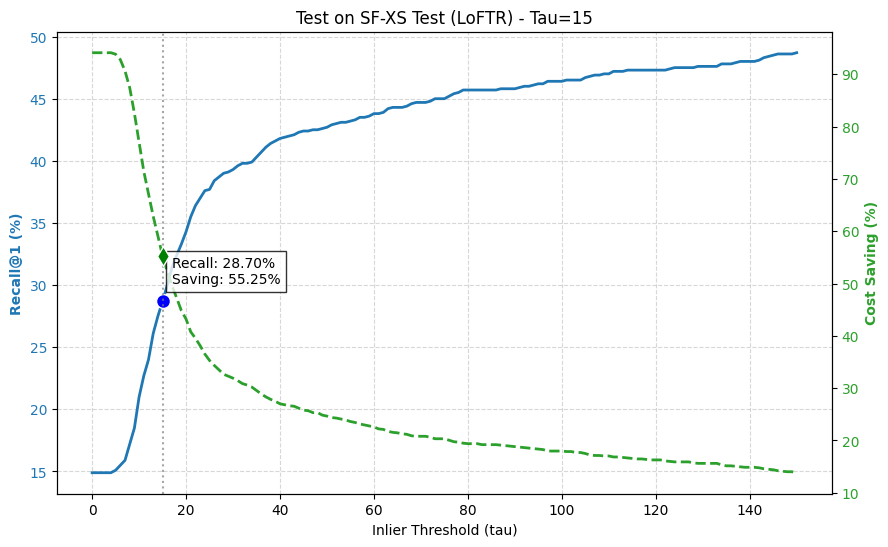



📊 FINAL TEST RESULTS (LoFTR - Adaptive Tau=15)
Dataset              | Recall@1     | Saving      
------------------------------------------------------------
SF-XS Test           | 28.70      % | 55.25      %


In [10]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

# ==============================================================================
# 1. CONFIGURAZIONE
# ==============================================================================
# Percorso per SF-XS TEST (Verifica il path esatto nel tuo Drive)
PATH_SF_XS_TEST = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_sf_xs/test"

CHOSEN_TAU = 15
TIME_GLOBAL = 0.20
TIME_RERANK = 3.20

# ==============================================================================
# 2. CARICAMENTO DATI
# ==============================================================================
def get_test_data(base_path, dataset_name):
    folder_name = 'preds_loftr'

    # Lista estesa di possibili nomi CSV per trovarlo sicuramente
    possible_csvs = [
        os.path.join(base_path, 'loftr_sf_xs_test.csv'), # Nome specifico probabile
        os.path.join(base_path, 'loftr_test.csv'),
        os.path.join(base_path, 'stats_preds_loftr.csv'),
        os.path.join(base_path, 'loftr.csv')
    ]

    csv_file = None
    for p in possible_csvs:
        if os.path.exists(p):
            csv_file = p
            break

    preds_folder = os.path.join(base_path, folder_name)

    print(f"\n--- Caricamento {dataset_name} ---")
    if not csv_file:
        print(f"❌ Errore: Nessun CSV trovato in {base_path}")
        print(f"   Ho cercato: {[os.path.basename(x) for x in possible_csvs]}")
        return pd.DataFrame()

    print(f"📄 CSV trovato: {os.path.basename(csv_file)}")
    df = pd.read_csv(csv_file)
    results = []

    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Reading {dataset_name}"):
        try:
            q_id = int(float(row['query_id']))
            final_is_correct = row['is_correct']

            # Cerca file .torch
            possible_names = [f"{q_id}.torch", f"{q_id:03d}.torch", f"{q_id:05d}.torch"]
            torch_path = None
            for name in possible_names:
                p = os.path.join(preds_folder, name)
                if os.path.exists(p):
                    torch_path = p
                    break

            if torch_path:
                data = torch.load(torch_path, weights_only=False)
                inliers_rank0 = data[0]['num_inliers']

                all_inliers = [x['num_inliers'] for x in data]
                is_rank0_best = (inliers_rank0 == max(all_inliers))
                rank0_ok = 1 if (is_rank0_best and final_is_correct == 1) else 0

                results.append({
                    'inliers_rank0': inliers_rank0,
                    'rank0_is_correct': rank0_ok,
                    'final_is_correct': final_is_correct
                })
        except:
            continue

    return pd.DataFrame(results)

# ==============================================================================
# 3. CALCOLO CURVE E PLOT
# ==============================================================================
def plot_results(df, dataset_name, chosen_tau):
    max_inl = int(df['inliers_rank0'].max())
    plot_limit = min(max_inl, 150) # Zoom ragionevole
    thresholds = np.arange(0, max_inl + 1, 1)

    recalls, savings = [], []
    total = len(df)
    full_time = total * (TIME_GLOBAL + TIME_RERANK)

    for t in thresholds:
        is_easy = df['inliers_rank0'] > t
        hits = np.sum(np.where(is_easy, df['rank0_is_correct'], df['final_is_correct']))
        recalls.append((hits / total) * 100)

        n_easy = np.sum(is_easy)
        n_hard = total - n_easy
        curr_time = (n_easy * TIME_GLOBAL) + (n_hard * (TIME_GLOBAL + TIME_RERANK))
        savings.append((1 - (curr_time / full_time)) * 100)

    if chosen_tau < len(thresholds):
        val_rec = recalls[chosen_tau]
        val_sav = savings[chosen_tau]
    else:
        val_rec = recalls[-1]
        val_sav = savings[-1]

    # --- PLOT ---
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.set_xlabel('Inlier Threshold (tau)')
    ax1.set_ylabel('Recall@1 (%)', color='tab:blue', fontweight='bold')
    ax1.grid(True, linestyle='--', alpha=0.5)

    viz_th = thresholds[thresholds <= plot_limit]
    viz_rec = recalls[:len(viz_th)]
    viz_sav = savings[:len(viz_th)]

    l1, = ax1.plot(viz_th, viz_rec, color='tab:blue', linewidth=2, label='Recall@1')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Cost Saving (%)', color='tab:green', fontweight='bold')
    l2, = ax2.plot(viz_th, viz_sav, color='tab:green', linestyle='--', linewidth=2, label='Cost Saving')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    ax1.scatter(chosen_tau, val_rec, color='blue', s=100, zorder=5, edgecolors='white')
    ax2.scatter(chosen_tau, val_sav, color='green', s=100, marker='d', zorder=5, edgecolors='white')

    plt.axvline(x=chosen_tau, color='gray', linestyle=':', alpha=0.7)
    plt.title(f'Test on {dataset_name} (LoFTR) - Tau={chosen_tau}')

    text_str = f"Recall: {val_rec:.2f}%\nSaving: {val_sav:.2f}%"
    plt.text(chosen_tau + 2, 50, text_str, bbox=dict(facecolor='white', alpha=0.8))

    plt.show()

    return val_rec, val_sav

# ==============================================================================
# 4. MAIN
# ==============================================================================
if __name__ == "__main__":
    # --- SF-XS TEST ---
    df_sfxs = get_test_data(PATH_SF_XS_TEST, "SF-XS Test")
    r_sfxs, s_sfxs = 0, 0

    if not df_sfxs.empty:
        r_sfxs, s_sfxs = plot_results(df_sfxs, "SF-XS Test", CHOSEN_TAU)

    # --- TABELLA FINALE ---
    print("\n\n📊 FINAL TEST RESULTS (LoFTR - Adaptive Tau=15)")
    print("=" * 60)
    print(f"{'Dataset':<20} | {'Recall@1':<12} | {'Saving':<12}")
    print("-" * 60)
    print(f"{'SF-XS Test':<20} | {r_sfxs:<10.2f} % | {s_sfxs:<10.2f} %")
    print("=" * 60)

### Test tokyo_xs
Obiettivo: Effettuare l'ultimo test di generalizzazione sul dataset Tokyo eXtra Small (Tokyo-XS).
L'applicazione della soglia $\tau=15$ (appresa su Pittsburgh) a un contesto urbano asiatico densamente popolato e illuminato diversamente ci fornirà la conferma definitiva sulla robustezza dell'approccio.

Aspettative:Similmente a SF-XS, ci aspettiamo che il sistema mantenga un buon livello di risparmio computazionale, filtrando efficacemente le query facili senza compromettere drasticamente la Recall.


--- Caricamento Tokyo-XS Test ---
📄 CSV trovato: loftr_stats_final.csv


Reading Tokyo-XS Test: 100%|██████████| 315/315 [01:13<00:00,  4.31it/s]


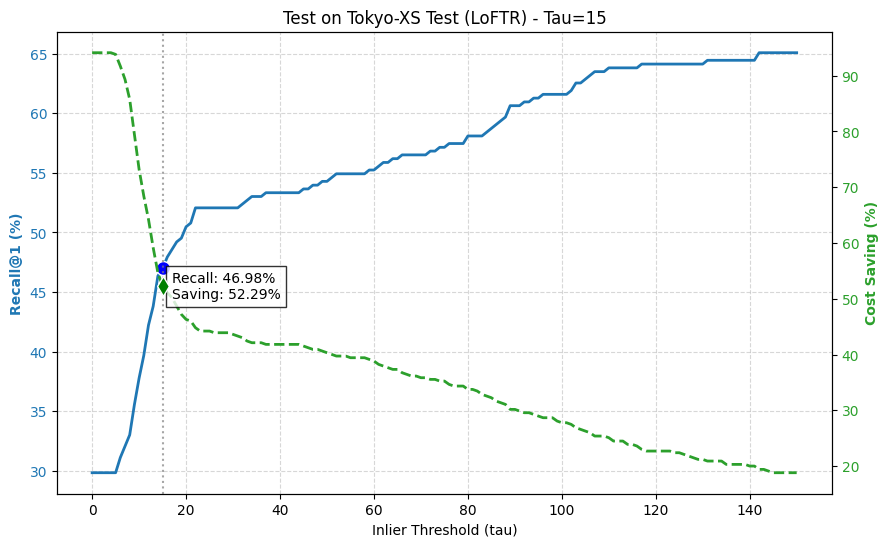



📊 FINAL TEST RESULTS (LoFTR - Adaptive Tau=15)
Dataset              | Recall@1     | Saving      
------------------------------------------------------------
Tokyo-XS Test        | 46.98      % | 52.29      %


In [11]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

# ==============================================================================
# 1. CONFIGURAZIONE
# ==============================================================================
# Percorso per TOKYO-XS (Solo Test)
PATH_TOKYO_TEST = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_tokyo"

CHOSEN_TAU = 15
TIME_GLOBAL = 0.20
TIME_RERANK = 3.20

# ==============================================================================
# 2. CARICAMENTO DATI
# ==============================================================================
def get_test_data(base_path, dataset_name):
    folder_name = 'preds_loftr'

    # Lista possibili nomi CSV per Tokyo
    possible_csvs = [
        os.path.join(base_path, 'loftr_tokyo_test.csv'),
        os.path.join(base_path, 'loftr_test.csv'),
        os.path.join(base_path, 'stats_preds_loftr.csv'),
        os.path.join(base_path, 'loftr.csv'),
        # A volte i file finali hanno nomi diversi, provo anche questo:
        os.path.join(base_path, 'loftr_stats_final.csv')
    ]

    csv_file = None
    for p in possible_csvs:
        if os.path.exists(p):
            csv_file = p
            break

    preds_folder = os.path.join(base_path, folder_name)

    print(f"\n--- Caricamento {dataset_name} ---")
    if not csv_file:
        print(f"❌ Errore: Nessun CSV trovato in {base_path}")
        print(f"   Ho cercato: {[os.path.basename(x) for x in possible_csvs]}")
        return pd.DataFrame()

    print(f"📄 CSV trovato: {os.path.basename(csv_file)}")
    df = pd.read_csv(csv_file)
    results = []

    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Reading {dataset_name}"):
        try:
            q_id = int(float(row['query_id']))
            final_is_correct = row['is_correct']

            # Cerca file .torch
            possible_names = [f"{q_id}.torch", f"{q_id:03d}.torch", f"{q_id:05d}.torch"]
            torch_path = None
            for name in possible_names:
                p = os.path.join(preds_folder, name)
                if os.path.exists(p):
                    torch_path = p
                    break

            if torch_path:
                data = torch.load(torch_path, weights_only=False)
                inliers_rank0 = data[0]['num_inliers']

                all_inliers = [x['num_inliers'] for x in data]
                is_rank0_best = (inliers_rank0 == max(all_inliers))
                rank0_ok = 1 if (is_rank0_best and final_is_correct == 1) else 0

                results.append({
                    'inliers_rank0': inliers_rank0,
                    'rank0_is_correct': rank0_ok,
                    'final_is_correct': final_is_correct
                })
        except:
            continue

    return pd.DataFrame(results)

# ==============================================================================
# 3. CALCOLO CURVE E PLOT
# ==============================================================================
def plot_results(df, dataset_name, chosen_tau):
    max_inl = int(df['inliers_rank0'].max())
    plot_limit = min(max_inl, 150)
    thresholds = np.arange(0, max_inl + 1, 1)

    recalls, savings = [], []
    total = len(df)
    full_time = total * (TIME_GLOBAL + TIME_RERANK)

    for t in thresholds:
        is_easy = df['inliers_rank0'] > t
        hits = np.sum(np.where(is_easy, df['rank0_is_correct'], df['final_is_correct']))
        recalls.append((hits / total) * 100)

        n_easy = np.sum(is_easy)
        n_hard = total - n_easy
        curr_time = (n_easy * TIME_GLOBAL) + (n_hard * (TIME_GLOBAL + TIME_RERANK))
        savings.append((1 - (curr_time / full_time)) * 100)

    if chosen_tau < len(thresholds):
        val_rec = recalls[chosen_tau]
        val_sav = savings[chosen_tau]
    else:
        val_rec = recalls[-1]
        val_sav = savings[-1]

    # --- PLOT ---
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.set_xlabel('Inlier Threshold (tau)')
    ax1.set_ylabel('Recall@1 (%)', color='tab:blue', fontweight='bold')
    ax1.grid(True, linestyle='--', alpha=0.5)

    viz_th = thresholds[thresholds <= plot_limit]
    viz_rec = recalls[:len(viz_th)]
    viz_sav = savings[:len(viz_th)]

    l1, = ax1.plot(viz_th, viz_rec, color='tab:blue', linewidth=2, label='Recall@1')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Cost Saving (%)', color='tab:green', fontweight='bold')
    l2, = ax2.plot(viz_th, viz_sav, color='tab:green', linestyle='--', linewidth=2, label='Cost Saving')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    ax1.scatter(chosen_tau, val_rec, color='blue', s=100, zorder=5, edgecolors='white')
    ax2.scatter(chosen_tau, val_sav, color='green', s=100, marker='d', zorder=5, edgecolors='white')

    plt.axvline(x=chosen_tau, color='gray', linestyle=':', alpha=0.7)
    plt.title(f'Test on {dataset_name} (LoFTR) - Tau={chosen_tau}')

    text_str = f"Recall: {val_rec:.2f}%\nSaving: {val_sav:.2f}%"
    plt.text(chosen_tau + 2, 50, text_str, bbox=dict(facecolor='white', alpha=0.8))

    plt.show()

    return val_rec, val_sav

# ==============================================================================
# 4. MAIN
# ==============================================================================
if __name__ == "__main__":
    # --- TOKYO-XS TEST ---
    df_tokyo = get_test_data(PATH_TOKYO_TEST, "Tokyo-XS Test")
    r_tok, s_tok = 0, 0

    if not df_tokyo.empty:
        r_tok, s_tok = plot_results(df_tokyo, "Tokyo-XS Test", CHOSEN_TAU)

    # --- TABELLA FINALE ---
    print("\n\n📊 FINAL TEST RESULTS (LoFTR - Adaptive Tau=15)")
    print("=" * 60)
    print(f"{'Dataset':<20} | {'Recall@1':<12} | {'Saving':<12}")
    print("-" * 60)
    print(f"{'Tokyo-XS Test':<20} | {r_tok:<10.2f} % | {s_tok:<10.2f} %")
    print("=" * 60)

## SuperPoint + LG

### TAU Svox Sun train SP+LG

Reading 712 queries for SP+LG...


100%|██████████| 712/712 [00:07<00:00, 95.01it/s] 


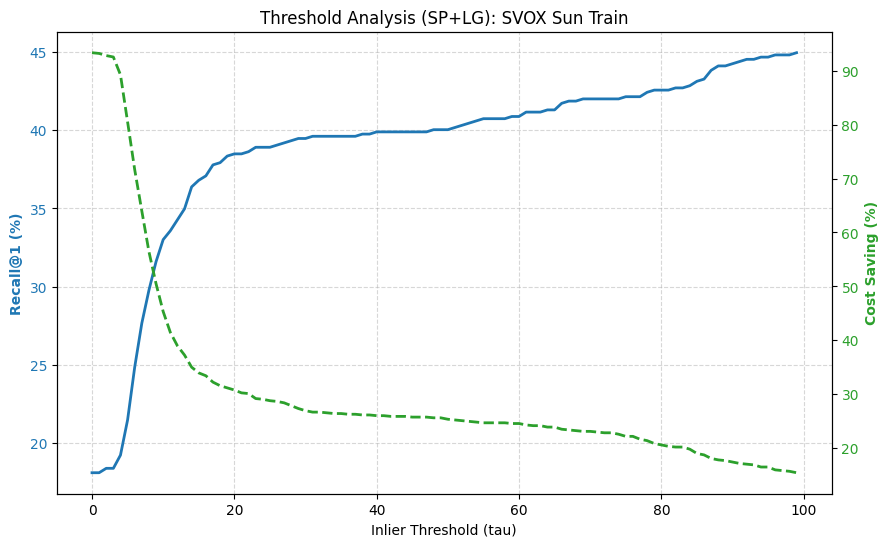


--- THRESHOLD TRADE-OFF TABLE (SP+LG, 0-100, Step 5) ---
Tau   | Recall     | Saving     | F1-Score   | Note
-----------------------------------------------------------------
0     | 18.12%   | 93.32%   | 0.6704     | 
5     | 21.49%   | 80.50%   | 0.6880     | 
10    | 33.01%   | 45.34%   | 0.7151     | ⭐ BEST
15    | 36.80%   | 33.97%   | 0.7273     | 
20    | 38.48%   | 30.80%   | 0.7128     | 
25    | 38.90%   | 28.82%   | 0.7140     | 
30    | 39.47%   | 26.97%   | 0.7069     | 
35    | 39.61%   | 26.44%   | 0.7048     | 
40    | 39.89%   | 26.04%   | 0.6978     | 
45    | 39.89%   | 25.78%   | 0.6931     | 
50    | 40.03%   | 25.38%   | 0.6897     | 
55    | 40.73%   | 24.72%   | 0.6777     | 
60    | 40.87%   | 24.59%   | 0.6752     | 
65    | 41.29%   | 23.93%   | 0.6630     | 
70    | 41.99%   | 23.13%   | 0.6479     | 
75    | 42.13%   | 22.21%   | 0.6300     | 
80    | 42.56%   | 20.62%   | 0.5981     | 
85    | 43.12%   | 19.04%   | 0.5686     | 
90    | 44.24%   | 17.45% 

In [ ]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from sklearn.metrics import f1_score

# ==============================================================================
# 1. CONFIGURATION
# ==============================================================================
BASE_PATH = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_svox/train/svox_sun_train"

# CHANGED: Pointing to SuperPoint+LightGlue folders
PREDS_FOLDER = os.path.join(BASE_PATH, 'preds_superpoint-lg')
CSV_FILE = os.path.join(BASE_PATH, 'stats_preds_superpoint-lg.csv')

# Latencies (seconds) - Adjust if SP+LG has different timings, but keeping consistent for now
TIME_GLOBAL = 0.20
TIME_RERANK = 3.20

# ==============================================================================
# 2. DATA LOADING
# ==============================================================================
def get_rank0_data(preds_folder, csv_file):
    if not os.path.exists(csv_file):
        print(f"❌ Error: CSV not found at {csv_file}")
        return pd.DataFrame()

    df = pd.read_csv(csv_file)
    results = []

    print(f"Reading {len(df)} queries for SP+LG...")
    for _, row in tqdm(df.iterrows(), total=len(df)):
        try:
            q_id = int(float(row['query_id']))
            final_is_correct = row['is_correct']

            # Search for .torch file
            possible_names = [f"{q_id}.torch", f"{q_id:03d}.torch", f"{q_id:05d}.torch"]
            torch_path = None
            for name in possible_names:
                p = os.path.join(preds_folder, name)
                if os.path.exists(p):
                    torch_path = p
                    break

            if torch_path:
                data = torch.load(torch_path, weights_only=False)
                inliers_rank0 = data[0]['num_inliers']

                # Check if Rank 0 is the best candidate and correct
                all_inliers = [x['num_inliers'] for x in data]
                is_rank0_best = (inliers_rank0 == max(all_inliers))
                rank0_ok = 1 if (is_rank0_best and final_is_correct == 1) else 0

                results.append({
                    'inliers_rank0': inliers_rank0,
                    'rank0_is_correct': rank0_ok,
                    'final_is_correct': final_is_correct
                })
        except Exception:
            continue

    return pd.DataFrame(results)

# ==============================================================================
# 3. ANALYSIS
# ==============================================================================
def run_analysis(df):
    max_inl = int(df['inliers_rank0'].max())
    thresholds = np.arange(0, max_inl + 1, 1)

    recalls, savings, f1_vals = [], [], []
    total = len(df)
    full_time = total * (TIME_GLOBAL + TIME_RERANK)

    for t in thresholds:
        is_easy = df['inliers_rank0'] > t

        # Recall@1
        hits = np.sum(np.where(is_easy, df['rank0_is_correct'], df['final_is_correct']))
        recalls.append((hits / total) * 100)

        # Saving
        n_easy = np.sum(is_easy)
        n_hard = total - n_easy
        curr_time = (n_easy * TIME_GLOBAL) + (n_hard * (TIME_GLOBAL + TIME_RERANK))
        savings.append((1 - (curr_time / full_time)) * 100)

        # F1 Score
        y_pred = (df['inliers_rank0'] > t).astype(int)
        f1_vals.append(f1_score(df['final_is_correct'], y_pred))

    return thresholds, recalls, savings, f1_vals

# ==============================================================================
# MAIN
# ==============================================================================
if __name__ == "__main__":
    df_results = get_rank0_data(PREDS_FOLDER, CSV_FILE)

    if not df_results.empty:
        th, rec, sav, f1 = run_analysis(df_results)

        # Find Global Best Tau
        best_idx = np.argmax(f1)
        best_tau_global = th[best_idx]

        # --- PLOT (Zoom 0-100 since SP+LG has fewer inliers) ---
        limit_idx = min(100, len(th))

        fig, ax1 = plt.subplots(figsize=(10, 6))
        ax1.set_xlabel('Inlier Threshold (tau)')
        ax1.set_ylabel('Recall@1 (%)', color='tab:blue', fontweight='bold')
        ax1.plot(th[:limit_idx], rec[:limit_idx], color='tab:blue', linewidth=2, label='Recall@1')
        ax1.tick_params(axis='y', labelcolor='tab:blue')
        ax1.grid(True, linestyle='--', alpha=0.5)

        ax2 = ax1.twinx()
        ax2.set_ylabel('Cost Saving (%)', color='tab:green', fontweight='bold')
        ax2.plot(th[:limit_idx], sav[:limit_idx], color='tab:green', linestyle='--', linewidth=2, label='Cost Saving')
        ax2.tick_params(axis='y', labelcolor='tab:green')

        plt.title('Threshold Analysis (SP+LG): SVOX Sun Train')
        plt.show()

        # --- TABLE (0-50, Step 2 is better for SP+LG, but using Step 5 as requested) ---
        print(f"\n--- THRESHOLD TRADE-OFF TABLE (SP+LG, 0-100, Step 5) ---")
        print(f"{'Tau':<5} | {'Recall':<10} | {'Saving':<10} | {'F1-Score':<10} | {'Note'}")
        print("-" * 65)

        # Iterating up to 60 (SP+LG usually saturates earlier)
        for t_val in range(0, 101, 5):
            if t_val < len(th):
                idx = t_val
                is_best = (abs(t_val - best_tau_global) < 3)
                marker = "⭐ BEST" if is_best else ""

                print(f"{t_val:<5} | {rec[idx]:.2f}%   | {sav[idx]:.2f}%   | {f1[idx]:.4f}     | {marker}")

        print("-" * 65)
        print(f"Note: Exact Mathematical Best Tau (step=1) is: {best_tau_global}")

### TAU Svox Night Train SP+LG

--- Analisi SVOX NIGHT TRAIN (SP+LG) ---
Lettura 702 query...


100%|██████████| 702/702 [03:52<00:00,  3.02it/s]


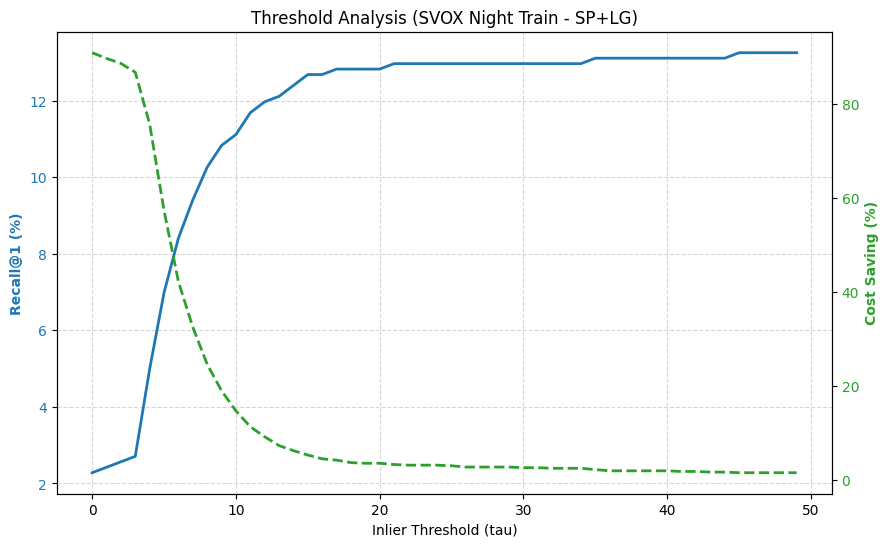


--- THRESHOLD TRADE-OFF TABLE (0-100, Step 5) ---
Tau   | Recall     | Saving     | F1-Score   | Note
-----------------------------------------------------------------
0     | 2.28%   | 90.90%   | 0.2429     | 
5     | 6.98%   | 57.38%   | 0.2328     | 
10    | 11.11%   | 14.75%   | 0.3107     | 
15    | 12.68%   | 5.36%   | 0.3088     | ⭐ BEST
20    | 12.82%   | 3.62%   | 0.3252     | 
25    | 12.96%   | 3.08%   | 0.3193     | 
30    | 12.96%   | 2.68%   | 0.3103     | 
35    | 13.11%   | 2.28%   | 0.2832     | 
40    | 13.11%   | 2.01%   | 0.2703     | 
45    | 13.25%   | 1.61%   | 0.2222     | 
50    | 13.25%   | 1.61%   | 0.2222     | 
55    | 13.25%   | 1.61%   | 0.2222     | 
60    | 13.39%   | 1.47%   | 0.2056     | 
65    | 13.39%   | 1.07%   | 0.1538     | 
70    | 13.53%   | 0.94%   | 0.1359     | 
75    | 13.53%   | 0.80%   | 0.1176     | 
80    | 13.53%   | 0.67%   | 0.0990     | 
85    | 13.53%   | 0.54%   | 0.0800     | 
90    | 13.68%   | 0.40%   | 0.0606     | 
95    |

In [12]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from sklearn.metrics import f1_score

# ==============================================================================
# 1. CONFIGURAZIONE (SVOX NIGHT TRAIN - SP+LG)
# ==============================================================================
# Percorso base
BASE_PATH = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_svox/train/svox_night_train"

# SuperPoint+LightGlue
PREDS_FOLDER = os.path.join(BASE_PATH, 'preds_superpoint-lg')
CSV_FILE = os.path.join(BASE_PATH, 'stats_preds_superpoint-lg.csv')

# Latencies (secondi)
TIME_GLOBAL = 0.20
TIME_RERANK = 3.20

# ==============================================================================
# 2. CARICAMENTO DATI
# ==============================================================================
def get_rank0_data(preds_folder, csv_file):
    print(f"--- Analisi SVOX NIGHT TRAIN (SP+LG) ---")
    if not os.path.exists(csv_file):
        print(f"❌ Errore: CSV non trovato in {csv_file}")
        return pd.DataFrame()

    df = pd.read_csv(csv_file)
    results = []

    print(f"Lettura {len(df)} query...")
    for _, row in tqdm(df.iterrows(), total=len(df)):
        try:
            q_id = int(float(row['query_id']))
            final_is_correct = row['is_correct']

            # Cerca file .torch
            possible_names = [f"{q_id}.torch", f"{q_id:03d}.torch", f"{q_id:05d}.torch"]
            torch_path = None
            for name in possible_names:
                p = os.path.join(preds_folder, name)
                if os.path.exists(p):
                    torch_path = p
                    break

            if torch_path:
                data = torch.load(torch_path, weights_only=False)
                inliers_rank0 = data[0]['num_inliers']

                # Check rank 0 correctness
                all_inliers = [x['num_inliers'] for x in data]
                is_rank0_best = (inliers_rank0 == max(all_inliers))
                rank0_ok = 1 if (is_rank0_best and final_is_correct == 1) else 0

                results.append({
                    'inliers_rank0': inliers_rank0,
                    'rank0_is_correct': rank0_ok,
                    'final_is_correct': final_is_correct
                })
        except Exception:
            continue

    return pd.DataFrame(results)

# ==============================================================================
# 3. ANALISI
# ==============================================================================
def run_analysis(df):
    max_inl = int(df['inliers_rank0'].max())
    # Per la notte e SP+LG, range basso e step 1 sono cruciali
    thresholds = np.arange(0, max_inl + 1, 1)

    recalls, savings, f1_vals = [], [], []
    total = len(df)
    full_time = total * (TIME_GLOBAL + TIME_RERANK)

    for t in thresholds:
        is_easy = df['inliers_rank0'] > t

        # Recall@1
        hits = np.sum(np.where(is_easy, df['rank0_is_correct'], df['final_is_correct']))
        recalls.append((hits / total) * 100)

        # Saving
        n_easy = np.sum(is_easy)
        n_hard = total - n_easy
        curr_time = (n_easy * TIME_GLOBAL) + (n_hard * (TIME_GLOBAL + TIME_RERANK))
        savings.append((1 - (curr_time / full_time)) * 100)

        # F1 Score
        y_pred = (df['inliers_rank0'] > t).astype(int)
        f1_vals.append(f1_score(df['final_is_correct'], y_pred))

    return thresholds, recalls, savings, f1_vals

# ==============================================================================
# MAIN
# ==============================================================================
if __name__ == "__main__":
    df_results = get_rank0_data(PREDS_FOLDER, CSV_FILE)

    if not df_results.empty:
        th, rec, sav, f1 = run_analysis(df_results)

        # Trova Best Tau
        best_idx = np.argmax(f1)
        best_tau_global = th[best_idx]

        # --- PLOT (Zoom stretto 0-50 per la notte SP+LG) ---
        limit_idx = min(50, len(th))

        fig, ax1 = plt.subplots(figsize=(10, 6))
        ax1.set_xlabel('Inlier Threshold (tau)')
        ax1.set_ylabel('Recall@1 (%)', color='tab:blue', fontweight='bold')
        ax1.plot(th[:limit_idx], rec[:limit_idx], color='tab:blue', linewidth=2, label='Recall@1')
        ax1.tick_params(axis='y', labelcolor='tab:blue')
        ax1.grid(True, linestyle='--', alpha=0.5)

        ax2 = ax1.twinx()
        ax2.set_ylabel('Cost Saving (%)', color='tab:green', fontweight='bold')
        ax2.plot(th[:limit_idx], sav[:limit_idx], color='tab:green', linestyle='--', linewidth=2, label='Cost Saving')
        ax2.tick_params(axis='y', labelcolor='tab:green')

        plt.title('Threshold Analysis (SVOX Night Train - SP+LG)')
        plt.show()

        # --- TABELLA (Step 5 come richiesto) ---
        print(f"\n--- THRESHOLD TRADE-OFF TABLE (0-100, Step 5) ---")
        print(f"{'Tau':<5} | {'Recall':<10} | {'Saving':<10} | {'F1-Score':<10} | {'Note'}")
        print("-" * 65)

        for t_val in range(0, 101, 5):
            if t_val < len(th):
                idx = t_val
                is_best = (abs(t_val - best_tau_global) <= 2)
                marker = "⭐ BEST" if is_best else ""

                print(f"{t_val:<5} | {rec[idx]:.2f}%   | {sav[idx]:.2f}%   | {f1[idx]:.4f}     | {marker}")

        print("-" * 65)
        print(f"Nota: Il Best Tau matematico esatto (step=1) è: {best_tau_global}")

### Validazione su sf_xs val
**TAU SCELTO: 12**

Obiettivo: Eseguiamo la validazione per il secondo metodo di matching: SuperPoint + LightGlue.Utilizziamo la soglia $\tau = 12$, determinata dall'analisi sul training set (SVOX Sun).
Aspettative: Poiché SP+LG produce meno inlier rispetto a LoFTR (essendo un metodo sparse), ci aspettiamo che la soglia di 12 sia sufficiente a distinguere i match buoni da quelli cattivi, garantendo un risparmio computazionale potenzialmente superiore a LoFTR a parità di Recall, grazie alla sua natura più selettiva.


--- Caricamento SUPERPOINT-LG su SF-XS VAL ---
📄 CSV trovato: superpoint-lg_val.csv


Loading superpoint-lg: 100%|██████████| 1000/1000 [05:15<00:00,  3.17it/s]


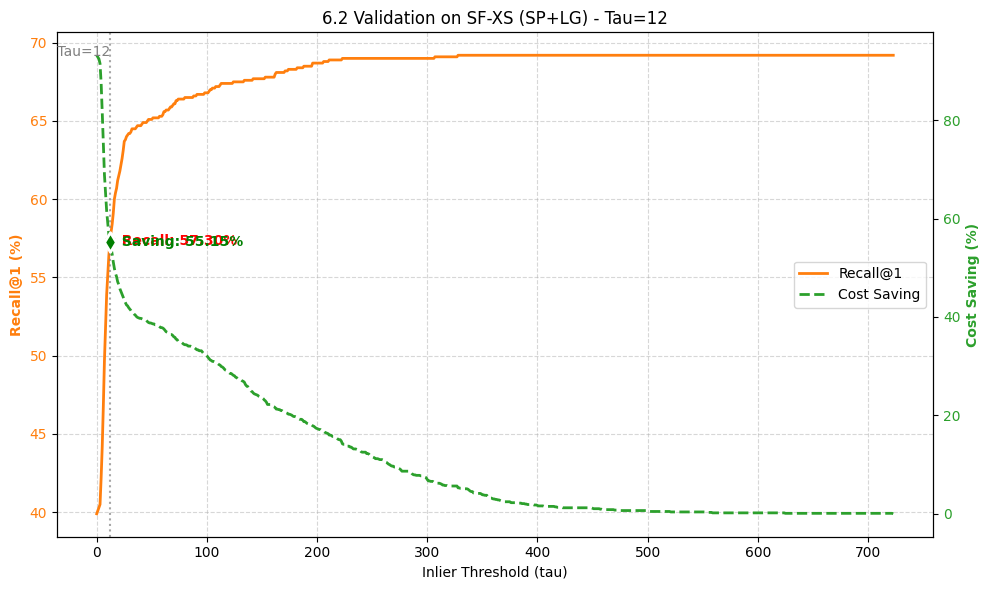


🏆 VALIDATION RESULTS (SF-XS VAL - SP+LG)
Method     | Chosen Tau | Recall@1   | Saving    
--------------------------------------------------
SP+LG      | 12         | 57.30     % | 55.15     %
--------------------------------------------------


In [13]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

# ==============================================================================
# 1. CONFIGURAZIONE VALIDAZIONE (SF-XS VAL - SP+LG)
# ==============================================================================
# Percorso base (lo stesso di LoFTR)
BASE_PATH = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_sf_xs/val"

# SOGLIA SCELTA (Congelata dalla fase di Training)
CHOSEN_TAU_SPLG = 12

# Latenze (secondi)
TIME_GLOBAL = 0.20
TIME_RERANK = 3.20

# ==============================================================================
# 2. FUNZIONI DI CARICAMENTO E ANALISI
# ==============================================================================
def get_rank0_data(base_path, matcher_name):
    # Cartella delle predizioni
    folder_name = 'preds_superpoint-lg'

    # Cerchiamo il CSV corretto.
    # Priorità: nome specifico visto negli screen > nome standard
    possible_csvs = [
        os.path.join(base_path, 'superpoint-lg_val.csv'),      # Visto nello screen
        os.path.join(base_path, f'stats_preds_{matcher_name}.csv'),
        os.path.join(base_path, f'{matcher_name}_val.csv')
    ]

    csv_file = None
    for p in possible_csvs:
        if os.path.exists(p):
            csv_file = p
            break

    preds_folder = os.path.join(base_path, folder_name)

    print(f"\n--- Caricamento {matcher_name.upper()} su SF-XS VAL ---")
    if not csv_file:
        print(f"❌ Errore: Nessun CSV trovato in {base_path}")
        print(f"   Ho cercato: {[os.path.basename(x) for x in possible_csvs]}")
        return pd.DataFrame()

    print(f"📄 CSV trovato: {os.path.basename(csv_file)}")
    df = pd.read_csv(csv_file)
    results = []

    # Lettura e parsing
    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Loading {matcher_name}"):
        try:
            q_id = int(float(row['query_id']))
            final_is_correct = row['is_correct']

            # Cerca file .torch
            possible_names = [f"{q_id}.torch", f"{q_id:03d}.torch", f"{q_id:05d}.torch"]
            torch_path = None
            for name in possible_names:
                p = os.path.join(preds_folder, name)
                if os.path.exists(p):
                    torch_path = p
                    break

            if torch_path:
                data = torch.load(torch_path, weights_only=False)
                inliers_rank0 = data[0]['num_inliers']

                # Calcola se il Rank 0 (Global Retrieval) era corretto
                all_inliers = [x['num_inliers'] for x in data]
                is_rank0_best = (inliers_rank0 == max(all_inliers))
                rank0_ok = 1 if (is_rank0_best and final_is_correct == 1) else 0

                results.append({
                    'inliers_rank0': inliers_rank0,
                    'rank0_is_correct': rank0_ok,
                    'final_is_correct': final_is_correct
                })
        except:
            continue

    return pd.DataFrame(results)

def validate_matcher(df, chosen_tau):
    max_inl = int(df['inliers_rank0'].max())
    thresholds = np.arange(0, max_inl + 1, 1)
    recalls, savings = [], []
    total = len(df)
    full_time = total * (TIME_GLOBAL + TIME_RERANK)

    for t in thresholds:
        is_easy = df['inliers_rank0'] > t

        # Recall@1
        hits = np.sum(np.where(is_easy, df['rank0_is_correct'], df['final_is_correct']))
        recalls.append((hits / total) * 100)

        # Saving
        n_easy = np.sum(is_easy)
        n_hard = total - n_easy
        curr_time = (n_easy * TIME_GLOBAL) + (n_hard * (TIME_GLOBAL + TIME_RERANK))
        savings.append((1 - (curr_time / full_time)) * 100)

    if chosen_tau < len(thresholds):
        val_recall = recalls[chosen_tau]
        val_saving = savings[chosen_tau]
    else:
        val_recall = recalls[-1]
        val_saving = savings[-1]

    return thresholds, recalls, savings, val_recall, val_saving

# ==============================================================================
# 3. MAIN: VALIDAZIONE E PLOT (SP+LG)
# ==============================================================================
if __name__ == "__main__":
    # --- 1. Caricamento Dati SP+LG ---
    df_splg = get_rank0_data(BASE_PATH, 'superpoint-lg')

    if not df_splg.empty:
        # Validazione
        th_s, rec_s, sav_s, val_rec_s, val_sav_s = validate_matcher(df_splg, CHOSEN_TAU_SPLG)

        # --- 2. GRAFICO DI VALIDAZIONE ---
        fig, ax1 = plt.subplots(figsize=(10, 6))

        ax1.set_xlabel('Inlier Threshold (tau)')
        ax1.set_ylabel('Recall@1 (%)', color='tab:orange', fontweight='bold')
        ax1.grid(True, linestyle='--', alpha=0.5)

        # Curva Recall (Arancione)
        l1, = ax1.plot(th_s, rec_s, color='tab:orange', linestyle='-', linewidth=2, label='Recall@1')
        ax1.tick_params(axis='y', labelcolor='tab:orange')

        # Curva Saving (Verde - Asse Destro)
        ax2 = ax1.twinx()
        ax2.set_ylabel('Cost Saving (%)', color='tab:green', fontweight='bold')
        l2, = ax2.plot(th_s, sav_s, color='tab:green', linestyle='--', linewidth=2, label='Cost Saving')
        ax2.tick_params(axis='y', labelcolor='tab:green')

        # --- PUNTO DI VALIDAZIONE (TAU = 12) ---
        # Pallino sulla Recall
        ax1.scatter(CHOSEN_TAU_SPLG, val_rec_s, color='red', s=100, zorder=5, edgecolors='white', linewidth=2)
        ax1.text(CHOSEN_TAU_SPLG + 2, val_rec_s, f"  Recall: {val_rec_s:.2f}%", color='red', fontsize=10, fontweight='bold', va='center')

        # Pallino sul Saving
        ax2.scatter(CHOSEN_TAU_SPLG, val_sav_s, color='green', s=100, marker='d', zorder=5, edgecolors='white', linewidth=2)
        ax2.text(CHOSEN_TAU_SPLG + 2, val_sav_s, f"  Saving: {val_sav_s:.2f}%", color='green', fontsize=10, fontweight='bold', va='center')

        # Linea verticale
        plt.axvline(x=CHOSEN_TAU_SPLG, color='gray', linestyle=':', alpha=0.7)
        plt.text(CHOSEN_TAU_SPLG, ax2.get_ylim()[1]*0.95, f" Tau={CHOSEN_TAU_SPLG}", color='gray', ha='right', fontsize=10)

        plt.title(f'6.2 Validation on SF-XS (SP+LG) - Tau={CHOSEN_TAU_SPLG}')

        # Legenda
        lines = [l1, l2]
        ax1.legend(lines, [l.get_label() for l in lines], loc='center right')

        plt.tight_layout()
        plt.show()

        # --- STAMPA TABELLA ---
        print("\n🏆 VALIDATION RESULTS (SF-XS VAL - SP+LG)")
        print(f"{'Method':<10} | {'Chosen Tau':<10} | {'Recall@1':<10} | {'Saving':<10}")
        print("-" * 50)
        print(f"{'SP+LG':<10} | {CHOSEN_TAU_SPLG:<10} | {val_rec_s:<10.2f}% | {val_sav_s:<10.2f}%")
        print("-" * 50)
    else:
        print("❌ Nessun dato trovato per SP+LG.")

### Test svox_sun e svox_night
Obiettivo: Valutare le prestazioni finali della strategia adattiva con SuperPoint + LightGlue sui dataset di test SVOX. Utilizziamo la soglia τ=12, determinata in fase di training e validata su SF-XS.

Analisi Attesa:

* SVOX Sun: Ci aspettiamo un buon risparmio computazionale, simile a quanto visto in validazione.
* SVOX Night: Data la natura "sparse" di SuperPoint e la difficoltà del notturno, ci aspettiamo (come per LoFTR) che il risparmio crolli drasticamente per preservare la Recall, poiché il sistema riconoscerà quasi tutte le query come "Difficili".


--- Caricamento SVOX Sun Test ---
📄 CSV trovato: superpoint-lg_queries_sun.csv


Reading SVOX Sun Test: 100%|██████████| 854/854 [04:07<00:00,  3.45it/s]


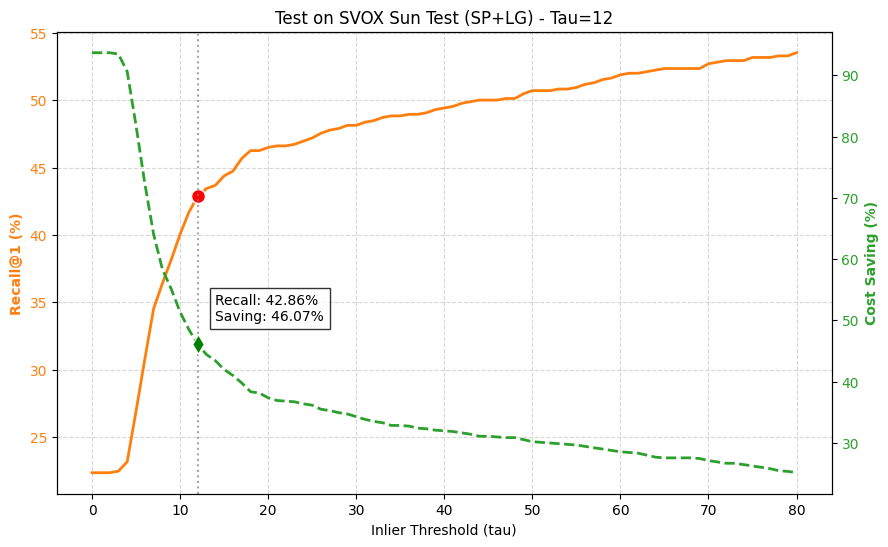


--- Caricamento SVOX Night Test ---
📄 CSV trovato: superpoint-lg_queries_night.csv


Reading SVOX Night Test: 100%|██████████| 823/823 [03:55<00:00,  3.50it/s]


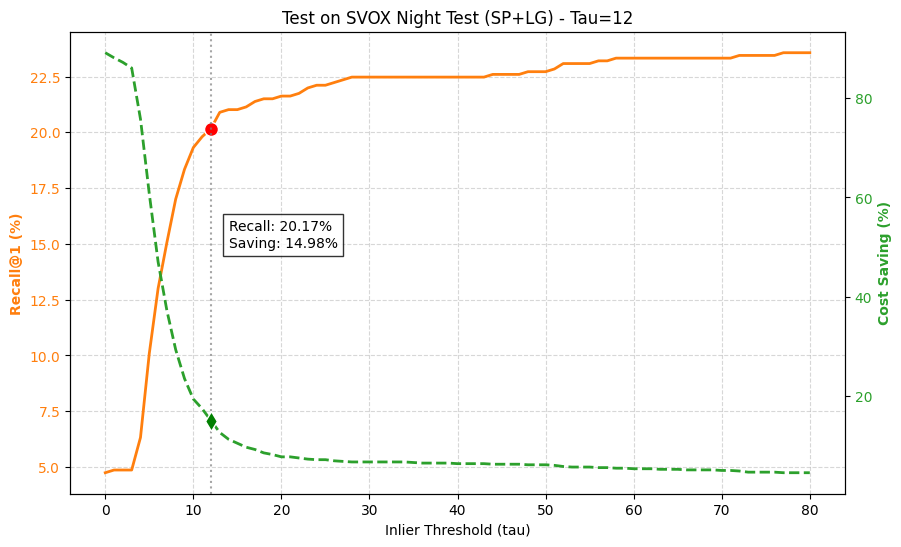



📊 FINAL TEST RESULTS (SP+LG - Adaptive Tau=12)
Dataset              | Recall@1     | Saving      
------------------------------------------------------------
SVOX Sun Test        | 42.86      % | 46.07      %
SVOX Night Test      | 20.17      % | 14.98      %


In [14]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

# ==============================================================================
# 1. CONFIGURAZIONE
# ==============================================================================
# Percorsi specifici SVOX Test
PATH_SUN_TEST = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_svox/test/svox_sun"
PATH_NIGHT_TEST = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_svox/test/svox_night"

# SOGLIA DEFINITIVA SP+LG
CHOSEN_TAU = 12

# Latenze (secondi)
TIME_GLOBAL = 0.20
TIME_RERANK = 3.20

# ==============================================================================
# 2. CARICAMENTO DATI
# ==============================================================================
def get_test_data(base_path, dataset_name):
    folder_name = 'preds_superpoint-lg' # Folder corretto

    # Cerchiamo i file specifici per SP+LG
    possible_csvs = [
        os.path.join(base_path, 'superpoint-lg_queries_sun.csv'),
        os.path.join(base_path, 'superpoint-lg_queries_night.csv'),
        os.path.join(base_path, 'superpoint-lg_test.csv'),
        os.path.join(base_path, 'stats_preds_superpoint-lg.csv')
    ]

    csv_file = None
    for p in possible_csvs:
        if os.path.exists(p):
            csv_file = p
            break

    preds_folder = os.path.join(base_path, folder_name)

    print(f"\n--- Caricamento {dataset_name} ---")
    if not csv_file:
        print(f"❌ Errore: Nessun CSV trovato in {base_path}")
        return pd.DataFrame()

    print(f"📄 CSV trovato: {os.path.basename(csv_file)}")
    df = pd.read_csv(csv_file)
    results = []

    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Reading {dataset_name}"):
        try:
            q_id = int(float(row['query_id']))
            final_is_correct = row['is_correct']

            # Cerca file .torch
            possible_names = [f"{q_id}.torch", f"{q_id:03d}.torch", f"{q_id:05d}.torch"]
            torch_path = None
            for name in possible_names:
                p = os.path.join(preds_folder, name)
                if os.path.exists(p):
                    torch_path = p
                    break

            if torch_path:
                data = torch.load(torch_path, weights_only=False)
                inliers_rank0 = data[0]['num_inliers']

                all_inliers = [x['num_inliers'] for x in data]
                is_rank0_best = (inliers_rank0 == max(all_inliers))
                rank0_ok = 1 if (is_rank0_best and final_is_correct == 1) else 0

                results.append({
                    'inliers_rank0': inliers_rank0,
                    'rank0_is_correct': rank0_ok,
                    'final_is_correct': final_is_correct
                })
        except:
            continue

    return pd.DataFrame(results)

# ==============================================================================
# 3. CALCOLO CURVE E PLOT
# ==============================================================================
def plot_results(df, dataset_name, chosen_tau):
    # Calcolo su tutto il range per disegnare la curva
    max_inl = int(df['inliers_rank0'].max())
    # Limitiamo il grafico a 60 per SP+LG (ha meno inlier di LoFTR)
    plot_limit = min(max_inl, 80)
    thresholds = np.arange(0, max_inl + 1, 1)

    recalls, savings = [], []
    total = len(df)
    full_time = total * (TIME_GLOBAL + TIME_RERANK)

    for t in thresholds:
        is_easy = df['inliers_rank0'] > t
        hits = np.sum(np.where(is_easy, df['rank0_is_correct'], df['final_is_correct']))
        recalls.append((hits / total) * 100)

        n_easy = np.sum(is_easy)
        n_hard = total - n_easy
        curr_time = (n_easy * TIME_GLOBAL) + (n_hard * (TIME_GLOBAL + TIME_RERANK))
        savings.append((1 - (curr_time / full_time)) * 100)

    # Dati puntuali per il Tau scelto
    if chosen_tau < len(thresholds):
        val_rec = recalls[chosen_tau]
        val_sav = savings[chosen_tau]
    else:
        val_rec = recalls[-1]
        val_sav = savings[-1]

    # --- PLOT ---
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.set_xlabel('Inlier Threshold (tau)')
    ax1.set_ylabel('Recall@1 (%)', color='tab:orange', fontweight='bold') # Arancione per SP+LG
    ax1.grid(True, linestyle='--', alpha=0.5)

    # Plot curve fino al limite visivo
    viz_th = thresholds[thresholds <= plot_limit]
    viz_rec = recalls[:len(viz_th)]
    viz_sav = savings[:len(viz_th)]

    l1, = ax1.plot(viz_th, viz_rec, color='tab:orange', linewidth=2, label='Recall@1')
    ax1.tick_params(axis='y', labelcolor='tab:orange')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Cost Saving (%)', color='tab:green', fontweight='bold')
    l2, = ax2.plot(viz_th, viz_sav, color='tab:green', linestyle='--', linewidth=2, label='Cost Saving')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    # Evidenzia punto scelto
    ax1.scatter(chosen_tau, val_rec, color='red', s=100, zorder=5, edgecolors='white')
    ax2.scatter(chosen_tau, val_sav, color='green', s=100, marker='d', zorder=5, edgecolors='white')

    plt.axvline(x=chosen_tau, color='gray', linestyle=':', alpha=0.7)
    plt.title(f'Test on {dataset_name} (SP+LG) - Tau={chosen_tau}')

    # Annotazione risultati
    text_str = f"Recall: {val_rec:.2f}%\nSaving: {val_sav:.2f}%"
    plt.text(chosen_tau + 2, 50, text_str, bbox=dict(facecolor='white', alpha=0.8))

    plt.show()

    return val_rec, val_sav

# ==============================================================================
# 4. MAIN
# ==============================================================================
if __name__ == "__main__":
    # --- SUN TEST ---
    df_sun = get_test_data(PATH_SUN_TEST, "SVOX Sun Test")
    r_sun, s_sun = 0, 0
    if not df_sun.empty:
        r_sun, s_sun = plot_results(df_sun, "SVOX Sun Test", CHOSEN_TAU)

    # --- NIGHT TEST ---
    df_night = get_test_data(PATH_NIGHT_TEST, "SVOX Night Test")
    r_night, s_night = 0, 0
    if not df_night.empty:
        r_night, s_night = plot_results(df_night, "SVOX Night Test", CHOSEN_TAU)

    # --- TABELLA FINALE ---
    print("\n\n📊 FINAL TEST RESULTS (SP+LG - Adaptive Tau=12)")
    print("=" * 60)
    print(f"{'Dataset':<20} | {'Recall@1':<12} | {'Saving':<12}")
    print("-" * 60)
    print(f"{'SVOX Sun Test':<20} | {r_sun:<10.2f} % | {s_sun:<10.2f} %")
    print(f"{'SVOX Night Test':<20} | {r_night:<10.2f} % | {s_night:<10.2f} %")
    print("=" * 60)

### Test sf_xs
Obiettivo: Valutare le prestazioni di SuperPoint + LightGlue sul dataset di test di San Francisco, utilizzando la soglia $\tau = 12$.

Aspettative: Confermare se il comportamento osservato in validazione (Recall leggermente superiore a LoFTR e Risparmio simile) si mantiene anche sul test set finale.


--- Caricamento SF-XS Test ---
📄 CSV trovato: superpoint-lg_test.csv


Reading SF-XS Test: 100%|██████████| 1000/1000 [05:21<00:00,  3.11it/s]


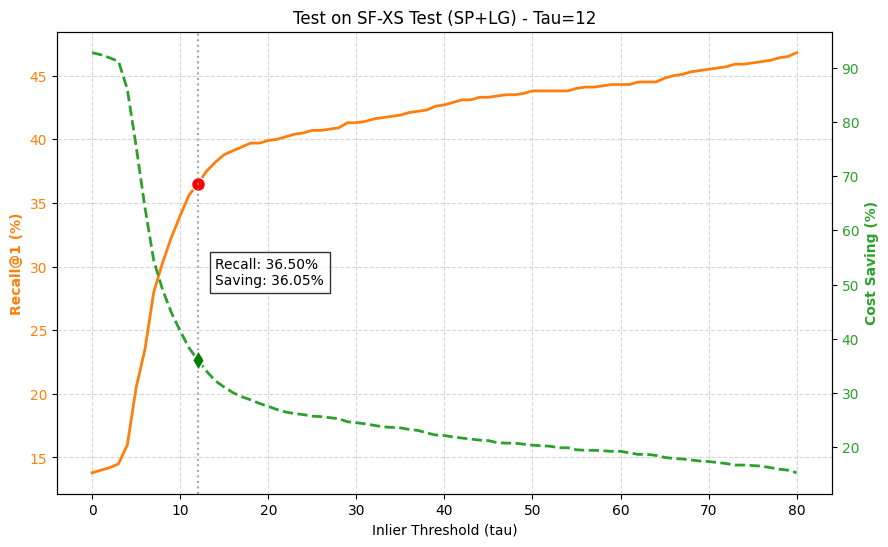



📊 FINAL TEST RESULTS (SP+LG - Adaptive Tau=12)
Dataset              | Recall@1     | Saving      
------------------------------------------------------------
SF-XS Test           | 36.50      % | 36.05      %


In [16]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

# ==============================================================================
# 1. CONFIGURAZIONE
# ==============================================================================
# Percorso per SF-XS TEST
PATH_SF_XS_TEST = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_sf_xs/test"

# SOGLIA SP+LG
CHOSEN_TAU = 12

# Latenze
TIME_GLOBAL = 0.20
TIME_RERANK = 3.20

# ==============================================================================
# 2. CARICAMENTO DATI
# ==============================================================================
def get_test_data(base_path, dataset_name):
    folder_name = 'preds_superpoint-lg'

    # Lista possibili nomi CSV per SP+LG
    possible_csvs = [
        os.path.join(base_path, 'superpoint-lg_sf_xs_test.csv'),
        os.path.join(base_path, 'superpoint-lg_test.csv'),
        os.path.join(base_path, 'stats_preds_superpoint-lg.csv'),
        os.path.join(base_path, 'superpoint-lg.csv')
    ]

    csv_file = None
    for p in possible_csvs:
        if os.path.exists(p):
            csv_file = p
            break

    preds_folder = os.path.join(base_path, folder_name)

    print(f"\n--- Caricamento {dataset_name} ---")
    if not csv_file:
        print(f"❌ Errore: Nessun CSV trovato in {base_path}")
        print(f"   Ho cercato: {[os.path.basename(x) for x in possible_csvs]}")
        return pd.DataFrame()

    print(f"📄 CSV trovato: {os.path.basename(csv_file)}")
    df = pd.read_csv(csv_file)
    results = []

    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Reading {dataset_name}"):
        try:
            q_id = int(float(row['query_id']))
            final_is_correct = row['is_correct']

            # Cerca file .torch
            possible_names = [f"{q_id}.torch", f"{q_id:03d}.torch", f"{q_id:05d}.torch"]
            torch_path = None
            for name in possible_names:
                p = os.path.join(preds_folder, name)
                if os.path.exists(p):
                    torch_path = p
                    break

            if torch_path:
                data = torch.load(torch_path, weights_only=False)
                inliers_rank0 = data[0]['num_inliers']

                all_inliers = [x['num_inliers'] for x in data]
                is_rank0_best = (inliers_rank0 == max(all_inliers))
                rank0_ok = 1 if (is_rank0_best and final_is_correct == 1) else 0

                results.append({
                    'inliers_rank0': inliers_rank0,
                    'rank0_is_correct': rank0_ok,
                    'final_is_correct': final_is_correct
                })
        except:
            continue

    return pd.DataFrame(results)

# ==============================================================================
# 3. CALCOLO CURVE E PLOT
# ==============================================================================
def plot_results(df, dataset_name, chosen_tau):
    max_inl = int(df['inliers_rank0'].max())
    # Zoom a 80 per SP+LG (ha meno inlier di LoFTR)
    plot_limit = min(max_inl, 80)
    thresholds = np.arange(0, max_inl + 1, 1)

    recalls, savings = [], []
    total = len(df)
    full_time = total * (TIME_GLOBAL + TIME_RERANK)

    for t in thresholds:
        is_easy = df['inliers_rank0'] > t
        hits = np.sum(np.where(is_easy, df['rank0_is_correct'], df['final_is_correct']))
        recalls.append((hits / total) * 100)

        n_easy = np.sum(is_easy)
        n_hard = total - n_easy
        curr_time = (n_easy * TIME_GLOBAL) + (n_hard * (TIME_GLOBAL + TIME_RERANK))
        savings.append((1 - (curr_time / full_time)) * 100)

    if chosen_tau < len(thresholds):
        val_rec = recalls[chosen_tau]
        val_sav = savings[chosen_tau]
    else:
        val_rec = recalls[-1]
        val_sav = savings[-1]

    # --- PLOT ---
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.set_xlabel('Inlier Threshold (tau)')
    ax1.set_ylabel('Recall@1 (%)', color='tab:orange', fontweight='bold')
    ax1.grid(True, linestyle='--', alpha=0.5)

    viz_th = thresholds[thresholds <= plot_limit]
    viz_rec = recalls[:len(viz_th)]
    viz_sav = savings[:len(viz_th)]

    # Arancione per SP+LG
    l1, = ax1.plot(viz_th, viz_rec, color='tab:orange', linewidth=2, label='Recall@1')
    ax1.tick_params(axis='y', labelcolor='tab:orange')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Cost Saving (%)', color='tab:green', fontweight='bold')
    l2, = ax2.plot(viz_th, viz_sav, color='tab:green', linestyle='--', linewidth=2, label='Cost Saving')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    # Evidenzia punto
    ax1.scatter(chosen_tau, val_rec, color='red', s=100, zorder=5, edgecolors='white')
    ax2.scatter(chosen_tau, val_sav, color='green', s=100, marker='d', zorder=5, edgecolors='white')

    plt.axvline(x=chosen_tau, color='gray', linestyle=':', alpha=0.7)
    plt.title(f'Test on {dataset_name} (SP+LG) - Tau={chosen_tau}')

    text_str = f"Recall: {val_rec:.2f}%\nSaving: {val_sav:.2f}%"
    plt.text(chosen_tau + 2, 50, text_str, bbox=dict(facecolor='white', alpha=0.8))

    plt.show()

    return val_rec, val_sav

# ==============================================================================
# 4. MAIN
# ==============================================================================
if __name__ == "__main__":
    # --- SF-XS TEST ---
    df_sfxs = get_test_data(PATH_SF_XS_TEST, "SF-XS Test")
    r_sfxs, s_sfxs = 0, 0

    if not df_sfxs.empty:
        r_sfxs, s_sfxs = plot_results(df_sfxs, "SF-XS Test", CHOSEN_TAU)

    # --- TABELLA FINALE ---
    print("\n\n📊 FINAL TEST RESULTS (SP+LG - Adaptive Tau=12)")
    print("=" * 60)
    print(f"{'Dataset':<20} | {'Recall@1':<12} | {'Saving':<12}")
    print("-" * 60)
    print(f"{'SF-XS Test':<20} | {r_sfxs:<10.2f} % | {s_sfxs:<10.2f} %")
    print("=" * 60)

### Test tokyo_xs
Obiettivo:
Concludiamo la sperimentazione applicando SuperPoint + LightGlue con soglia $\tau=12$ al dataset Tokyo-XS.
Questo test finale ci permetterà di confrontare la generalizzazione di SP+LG rispetto a LoFTR in un ambiente urbano complesso e diverso da quelli di training.


--- Caricamento Tokyo-XS Test ---
📄 CSV trovato: superpoint-lg_stats_final.csv


Reading Tokyo-XS Test: 100%|██████████| 315/315 [01:45<00:00,  2.99it/s]


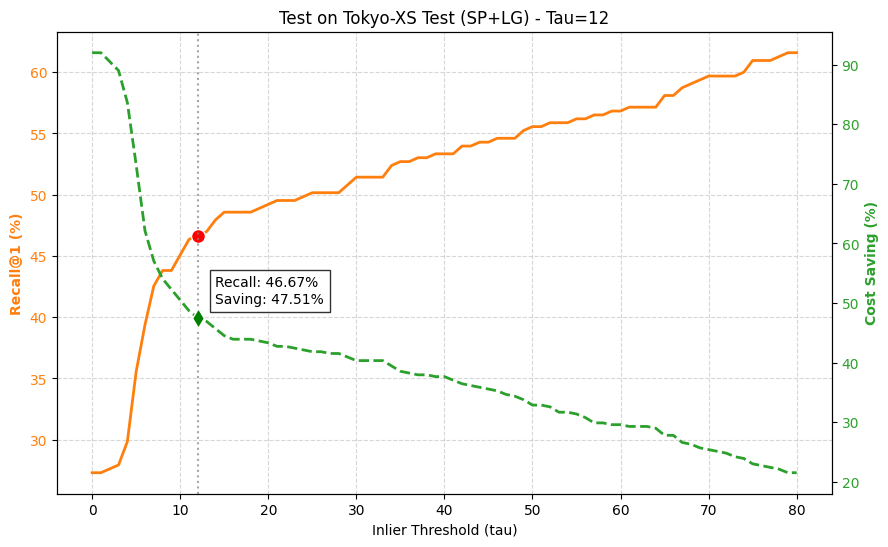



📊 FINAL TEST RESULTS (SP+LG - Adaptive Tau=12)
Dataset              | Recall@1     | Saving      
------------------------------------------------------------
Tokyo-XS Test        | 46.67      % | 47.51      %


In [17]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

# ==============================================================================
# 1. CONFIGURAZIONE
# ==============================================================================
# Percorso per TOKYO-XS (Solo Test)
PATH_TOKYO_TEST = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_tokyo"

# SOGLIA SP+LG
CHOSEN_TAU = 12

# Latenze
TIME_GLOBAL = 0.20
TIME_RERANK = 3.20

# ==============================================================================
# 2. CARICAMENTO DATI
# ==============================================================================
def get_test_data(base_path, dataset_name):
    folder_name = 'preds_superpoint-lg'

    # Lista possibili nomi CSV per Tokyo SP+LG
    possible_csvs = os.path.join(base_path, 'superpoint-lg_stats_final.csv'),

    csv_file = None
    for p in possible_csvs:
        if os.path.exists(p):
            csv_file = p
            break

    preds_folder = os.path.join(base_path, folder_name)

    print(f"\n--- Caricamento {dataset_name} ---")
    if not csv_file:
        print(f"❌ Errore: Nessun CSV trovato in {base_path}")
        print(f"   Ho cercato: {[os.path.basename(x) for x in possible_csvs]}")
        return pd.DataFrame()

    print(f"📄 CSV trovato: {os.path.basename(csv_file)}")
    df = pd.read_csv(csv_file)
    results = []

    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Reading {dataset_name}"):
        try:
            q_id = int(float(row['query_id']))
            final_is_correct = row['is_correct']

            # Cerca file .torch
            possible_names = [f"{q_id}.torch", f"{q_id:03d}.torch", f"{q_id:05d}.torch"]
            torch_path = None
            for name in possible_names:
                p = os.path.join(preds_folder, name)
                if os.path.exists(p):
                    torch_path = p
                    break

            if torch_path:
                data = torch.load(torch_path, weights_only=False)
                inliers_rank0 = data[0]['num_inliers']

                all_inliers = [x['num_inliers'] for x in data]
                is_rank0_best = (inliers_rank0 == max(all_inliers))
                rank0_ok = 1 if (is_rank0_best and final_is_correct == 1) else 0

                results.append({
                    'inliers_rank0': inliers_rank0,
                    'rank0_is_correct': rank0_ok,
                    'final_is_correct': final_is_correct
                })
        except:
            continue

    return pd.DataFrame(results)

# ==============================================================================
# 3. CALCOLO CURVE E PLOT
# ==============================================================================
def plot_results(df, dataset_name, chosen_tau):
    max_inl = int(df['inliers_rank0'].max())
    # Zoom a 80 per SP+LG
    plot_limit = min(max_inl, 80)
    thresholds = np.arange(0, max_inl + 1, 1)

    recalls, savings = [], []
    total = len(df)
    full_time = total * (TIME_GLOBAL + TIME_RERANK)

    for t in thresholds:
        is_easy = df['inliers_rank0'] > t
        hits = np.sum(np.where(is_easy, df['rank0_is_correct'], df['final_is_correct']))
        recalls.append((hits / total) * 100)

        n_easy = np.sum(is_easy)
        n_hard = total - n_easy
        curr_time = (n_easy * TIME_GLOBAL) + (n_hard * (TIME_GLOBAL + TIME_RERANK))
        savings.append((1 - (curr_time / full_time)) * 100)

    if chosen_tau < len(thresholds):
        val_rec = recalls[chosen_tau]
        val_sav = savings[chosen_tau]
    else:
        val_rec = recalls[-1]
        val_sav = savings[-1]

    # --- PLOT ---
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.set_xlabel('Inlier Threshold (tau)')
    ax1.set_ylabel('Recall@1 (%)', color='tab:orange', fontweight='bold')
    ax1.grid(True, linestyle='--', alpha=0.5)

    viz_th = thresholds[thresholds <= plot_limit]
    viz_rec = recalls[:len(viz_th)]
    viz_sav = savings[:len(viz_th)]

    # Arancione per SP+LG
    l1, = ax1.plot(viz_th, viz_rec, color='tab:orange', linewidth=2, label='Recall@1')
    ax1.tick_params(axis='y', labelcolor='tab:orange')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Cost Saving (%)', color='tab:green', fontweight='bold')
    l2, = ax2.plot(viz_th, viz_sav, color='tab:green', linestyle='--', linewidth=2, label='Cost Saving')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    # Evidenzia punto
    ax1.scatter(chosen_tau, val_rec, color='red', s=100, zorder=5, edgecolors='white')
    ax2.scatter(chosen_tau, val_sav, color='green', s=100, marker='d', zorder=5, edgecolors='white')

    plt.axvline(x=chosen_tau, color='gray', linestyle=':', alpha=0.7)
    plt.title(f'Test on {dataset_name} (SP+LG) - Tau={chosen_tau}')

    text_str = f"Recall: {val_rec:.2f}%\nSaving: {val_sav:.2f}%"
    plt.text(chosen_tau + 2, 50, text_str, bbox=dict(facecolor='white', alpha=0.8))

    plt.show()

    return val_rec, val_sav

# ==============================================================================
# 4. MAIN
# ==============================================================================
if __name__ == "__main__":
    # --- TOKYO-XS TEST ---
    df_tokyo = get_test_data(PATH_TOKYO_TEST, "Tokyo-XS Test")
    r_tok, s_tok = 0, 0

    if not df_tokyo.empty:
        r_tok, s_tok = plot_results(df_tokyo, "Tokyo-XS Test", CHOSEN_TAU)

    # --- TABELLA FINALE ---
    print("\n\n📊 FINAL TEST RESULTS (SP+LG - Adaptive Tau=12)")
    print("=" * 60)
    print(f"{'Dataset':<20} | {'Recall@1':<12} | {'Saving':<12}")
    print("-" * 60)
    print(f"{'Tokyo-XS Test':<20} | {r_tok:<10.2f} % | {s_tok:<10.2f} %")
    print("=" * 60)